In [202]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Statistics
using Plots
using DelimitedFiles
using DataFrames
using ProgressMeter
using StatsPlots
Threads.nthreads()

8

# Import data

In [2]:
#schneider data
all_schneider, train_data = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Helper functions needed for simulations

In [3]:
# gives 400/450/600 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# gives T4 dose at hour 24
function new_jonklaas_condition(u, t, integrator)
    return t - 24.0
end
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
function blakesley_t4_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_t3_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_tsh_neg_logl(sol, time, data, Vtsh, σ, λ = 0.0) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
        # add penalty for 1st and 2nd high/low peak in TSH data (no penalty if λ=0)           
        for i in [9, 13, 24, 28]
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += λ * (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
# μmol (thyrosim unit for FT4) = Vb/100/777 ng/dL (jonklaas unit)
function FT4_to_TT4(FT4, Vb)
    # FT4 in ng/dL. Need to convert it to μmol
    f(TT4) = (0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 - FT4 * Vb / 77700
    return fzero(f, 100)
end
# calculate new jonklaas error for T4 at end of sol
function jonklaas_T4_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][1] * 777.0 / Vp
        tot_loss += (predicted - FT4_to_TT4(data))^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for T3 at end of sol
function jonklaas_T3_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][4] * 651.0 / Vp
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for TSH at end of sol
function jonklaas_TSH_neg_logl(sol, data, Vtsh, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][7] * 5.6 / Vtsh
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
function schneider_end_tsh( 
    current_iter::Vector,
    fitting_index::Vector,
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    initial_tsh::Float64,
    initial_dose::Float64
    )

    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex, 
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode,
        scale_allometric_exponent=scale_allometric_exponent,scale_clearance_by_gender=scale_clearance_by_gender)
    ic[7] = initial_tsh
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= @view(current_iter[1:length(fitting_index)])

    # run ODE simulation
    p[55] = initial_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk) # simulate for 6 weeks
    sol   = solve(prob, save_idxs=[1, 7])

    # return observed value
    return sol.u[end][2] * 5.6 / p[48]
end
function schneider_TSH_err(initTSH, sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    return true
end
function TSH_within_interval(sol, Vtsh)
    tot_loss = 0
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end
# Calculate mean/std of eythyroid dose (mcg/kg) for 
# male and female patients in different BMI categories 
function compute_patient_categories(
    sex::AbstractVector, 
    bmi::AbstractVector,
    euthyroid_dose::AbstractVector
    )
    categories = Dict{Symbol, Tuple{Float64, Float64}}()
    
    # get index for different cateories
    male_normal_idx = intersect(findall(iszero, sex), findall(x -> x < 24.9, bmi))
    male_overweight_idx = intersect(findall(iszero, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    male_obese_idx = intersect(findall(iszero, sex), findall(x -> 29.9 <= x, bmi))
    female_normal_idx = intersect(findall(isone, sex), findall(x -> x < 24.9, bmi))
    female_overweight_idx = intersect(findall(isone, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    female_obese_idx = intersect(findall(isone, sex), findall(x -> 29.9 <= x, bmi))
    
    # compute mean and var of euthyroid dose. If empty, set both as 0
    categories[:male_normal] = isempty(male_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_normal_idx]), std(euthyroid_dose[male_normal_idx]))
    categories[:male_overweight] = isempty(male_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_overweight_idx]), std(euthyroid_dose[male_overweight_idx]))
    categories[:male_obese] = isempty(male_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_obese_idx]), std(euthyroid_dose[male_obese_idx]))
    categories[:female_normal] = isempty(female_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_normal_idx]), std(euthyroid_dose[female_normal_idx]))
    categories[:female_overweight] = isempty(female_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_overweight_idx]), std(euthyroid_dose[female_overweight_idx]))
    categories[:female_obese] = isempty(female_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_obese_idx]), std(euthyroid_dose[female_obese_idx]))

    return categories
end
# male = 0, female = 1. Height in meters and weight in kg
function get_category(categories::Dict, sex, height, weight)
    bmi = weight / height^2
    if sex == 0
        if bmi < 24.9 
            return categories[:male_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:male_overweight]
        elseif 29.9 <= bmi
            return categories[:male_obese]
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            return categories[:female_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:female_overweight]
        elseif 29.9 <= bmi
            return categories[:female_obese]
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end
function update_logl_by_category!(logl_by_category::Vector, logl, sex, height, weight)
    bmi = weight / height^2
    if sex == 0 # male
        if bmi < 24.9 
            logl_by_category[8] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[16] += logl
        elseif 29.9 <= bmi
            logl_by_category[24] += logl
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            logl_by_category[32] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[40] += logl
        elseif 29.9 <= bmi
            logl_by_category[48] += logl
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end

update_logl_by_category! (generic function with 1 method)

# Result (scale clearance by mass)

In [4]:
# 4 penalized + exclude 3 jonklaas + fit fat-free constants (diff init)
# scale plasma/slow/allometric ODE, not scaling clearance 
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73]              # reference BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5]
# train_minimizer = [0.002894500039900503, 0.01613220684554006, 85.9313655546565, 49.31487271512488, 
#     0.0719103236305483, 4.614008466371258, 4.394637268204977, 6.9785392795578804, 9.023371491989007, 
#     6.9501885710844356, 17.37790233665952, 24.68638086032489, 0.5153134475699228, 0.5606960917417546]
# scale_plasma_ode = true
# scale_slow_ode = true
# scale_fast_ode = false
# scale_allometric_exponent = true
# scale_clearance = false
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)



# 4 penalized + exclude 3 jonklaas + fit fat-free constants (diff init)
# not scaling anything 
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73]              # reference BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5]
# train_minimizer = [0.0028985736642342425, 0.01570749381231895, 68.4528703050755, 
#     38.137516836292406, 0.13856607550186945, 3.644879292309021, 4.268160473960672, 
#     11.264293894931926, 5.723784232161086, 7.7021941569118475, 19.901848742821937, 
#     20.653087230059157, 0.7003565433804877, 0.18810734988010291]
# scale_plasma_ode = false
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = false
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)



# 4 penalized + exclude 3 jonklaas + fit fat-free constants (diff init)
# scaling only clearance
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73]              # reference BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5]
# train_minimizer = [0.0029665095869060598, 0.01677405173262536, 82.97768786972411, 
#     48.06917233583551, 0.09051210567338924, 4.9488978252257505, 4.382209382377083, 
#     7.410735175124591, 8.19124059936456, 6.955421099123012, 17.893657130553773, 
#     24.49535855491063, 0.4762625711744255, 0.48813269755899175]
# scale_plasma_ode = false
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)

# Result (scale clearance by fat free mass)

In [5]:
# only scaling clearance by fat-free mass
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73]              # reference BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5]
# train_minimizer = [0.0029026026566620236, 0.01578131294930457, 86.42954422585314, 49.474389460512754, 
#     0.09608837975257463, 4.729501386401978, 4.406022643556557, 6.876297063174595, 8.391063268712564, 
#     6.852061457784772, 19.606503174315886, 20.333960012981798, 0.4479243502737814, 0.5325597826939238]
# scale_plasma_ode = false
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)


# scaling clearance (by fat free mass) and plasma ODE
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73]              # reference BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5]
# train_minimizer = [0.002902386773410254, 0.016418194323252797, 86.97875239357495, 50.183738985182366, 
#     0.07101077143458667, 4.7699412124065335, 4.426660403984123, 6.98199396735876, 9.213720607910775, 
#     6.945642842139604, 17.034474586464786, 23.483333567766024, 0.5203832528630542, 0.5322822565280847]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)


# scaling clearance by fat free mass and fitting clearance exponent
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73; 76]          # reference BMI, fat-free and fat constant, clearance exp
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5, 0.75]
# train_minimizer = [0.0029159895066258367, 0.015721623558700767, 90.06469805721144, 50.706274329837136, 
#     0.09232684019234756, 4.333217954576934, 4.509591159101574, 6.823965951850583, 9.040684154015453, 
#     6.836402753492972, 19.985288566298237, 20.39971101033884, 0.471536151934852, 0.5076393068028299, 
#     0.7458982820631145]
# scale_plasma_ode = false
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearanceFit_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)


# scaling clearance (by fat free mass), plasma ODE, and clearance exp
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68; 72; 73; 76]          # reference BMI, fat-free and fat constant, clearance exp
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 0.5, 0.5, 0.75]
# train_minimizer = [0.002913073380055502, 0.016425815404922217, 87.24512548211945, 49.87009878626854, 
#     0.07188529381564208, 4.770243302831388, 4.425311231903433, 7.339990245773605, 9.051891802721235, 
#     7.006031646060019, 17.194305354577164, 23.725016645484548, 0.5141750287928509, 0.5100229004348534, 
#     0.7803971457019127]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearanceFit_$(scale_clearance)/"
# isdir(dir) || mkdir(dir)



# scaling clearance (by fat free mass, not fitting clearance exp), and fitting 2 ref BMI
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73]          # reference male/female BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5]
# train_minimizer = [0.0028048691544352235, 0.015404912023898485, 87.17984120548246, 49.39439774953594, 
#     0.09349291669187143, 4.502679493556825, 4.455926037211944, 7.82757850301375, 9.05735889336575, 
#     6.689869081676641, 18.62922040488134, 21.201159305448776, 21.60547832995178, 0.505825742630138, 
#     0.5087755550537468]
# scale_plasma_ode = false
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
# isdir(dir) || mkdir(dir)

# scaling plasma ODE and clearance (by fat free mass, not fitting clearance exp), and fitting 2 ref BMI
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73]          # reference male/female BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5]
# train_minimizer = [0.002892325645176463, 0.01647822163155647, 85.5080038552951, 50.092042190460546,
#     0.07823531741800163, 4.631602288103847, 4.43040456736911, 7.444131475905966, 9.10698624650311, 
#     6.86200220854093, 17.834555230284582, 23.493539842856777, 22.74817798945791, 0.5087250210006445,
#     0.5197123420422401]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
# isdir(dir) || mkdir(dir)

# scaling plasma ODE, clearance (by fat free mass, not fitting clearance exp), allometric, and fitting 2 ref BMI
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73]          # reference male/female BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5]
# train_minimizer = [0.002871334974072354, 0.016379531900164113, 84.58545132370732, 48.35813168394228, 
#     0.08768482242651322, 4.481237032480003, 4.449872360605545, 7.021132347459909, 8.814199990042042, 
#     6.841563072647123, 17.089517434566627, 24.301966572754658, 23.537372497056168, 0.516533140534259, 
#     0.5078399821562003]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = true
# scale_clearance = true
# dir = "./plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
# isdir(dir) || mkdir(dir)

# male ref height = 1.7, scaling plasma ODE, clearance (by fat free mass, not fitting clearance exp), allometric, and fitting 2 ref BMI
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73]          # reference male/female BMI, fat-free and fat constant
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5]
# train_minimizer = [0.002953946230300814, 0.017331239361714237, 85.64166009396298, 49.70307152995834, 
#     0.07764119912196568, 4.719652446799605, 4.397604159573876, 6.663556565972885, 8.804608807983076, 
#     6.936485101748506, 16.892107017643646, 24.997081631205358, 22.886753335281682, 0.5288025224415615, 
#     0.5301389037251671]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./maleRefHeight1.7_plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
# isdir(dir) || mkdir(dir)

# fit male ref height, scaling plasma ODE, clearance (by fat free mass, not fitting clearance exp), allometric, and fitting 2 ref BMI
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
#     77]                      # male ref height
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 1.77]
# train_minimizer = [0.002901704288619699, 0.01650714787350305, 92.52504120700948, 54.07711896336609, 
#     0.07946680025441288, 4.31397466447349, 4.334789042656764, 7.23893486521068, 8.979414270465496,
#     6.819870795076371, 19.11378739957667, 24.093764419556088, 22.068072910837977, 0.5043123824486787, 
#     0.503457806807031, 1.76456328625]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = true
# dir = "./fitMaleRefHeight_plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
# isdir(dir) || mkdir(dir)

# Result (scaling plasma ODE but not oral doses)

In [6]:
# fit male ref height, 2 ref BMI
# scaling plasma ODE, clearance (by fat free mass, not fitting clearance exp), allometric
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31; 37               # A0, B0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
    77]                      # male ref height
initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 1.77]
train_minimizer = [0.0029130711262898043, 0.015576914117076004, 89.47645394720769, 52.35211503124652, 
    0.0795551753005582, 4.516090356092238, 4.381421055008935, 7.078894126723949, 8.94326988990513, 
    6.9282347372242254, 19.7071315151069, 24.390814208273493, 23.987415273794007, 0.4911316513612985,
    0.4783500084063195, 1.7671069589760309]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance = true
dir = "./noOralScaling_fitMaleRefHeight_plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
isdir(dir) || mkdir(dir)



# fit male clearance, fit male ref height, 2 ref BMI
# scaling plasma ODE, clearance (by fat free mass, not fitting clearance exp), allometric
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31; 37               # A0, B0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
    76; 78]                  # male allometric exponent for clearance, male ref height
initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 0.75, 1.77]
train_minimizer = [0.0029301880698956967, 0.015571388382808192, 86.94859707497521, 51.75837018630473, 
    0.07561066560219945, 4.451604235635586, 4.31065227344802, 7.411893470293615, 8.799389783914474, 
    6.897588000388539, 19.382336528454665, 24.8070782811342, 24.03659969111685, 0.49420954168341313, 
    0.49816925680079527, 0.7331769686291626, 1.7624991312115694]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance = true
dir = "./fitMaleCearlance_noOralScaling_fitMaleRefHeight_plasma_$(scale_plasma_ode)_slow_$(scale_slow_ode)_allom_$(scale_allometric_exponent)_clearance_$(scale_clearance)_2refBMI/"
isdir(dir) || mkdir(dir)




# fit male clearance, fit male ref height, 2 ref BMI, allometric clearance exp
# scaling plasma ODE, clearance (by mass)
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31; 37               # A0, B0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
    76; 78; 80]              # male allometric exponent for clearance, male ref height, male clearance scale
initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 0.75, 1.77, 1.5]
train_minimizer = [0.0029265246666830176, 0.01645623434886206, 91.75928142782276, 51.41244389508542, 
    0.06535326793470411, 4.23773713941622, 4.191808697761855, 7.52288979771252, 8.992591638086482, 
    6.807198946646077, 19.59125645384869, 24.913092083868378, 24.992466546675722, 0.5522039034878697, 
    0.5252701353119072, 0.767527948372327, 1.7645840652809086, 1.0874182626632076]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance = true
scale_clearance_fatfree = false
dir = "./fitMaleCearlanceMass_noOralScaling_2refBMI/"
isdir(dir) || mkdir(dir)



# fit male clearance, fit male ref height, 2 ref BMI, allometric clearance exp
# scaling plasma ODE, clearance (by fat free mass)
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
#     76; 78; 80]              # male allometric exponent for clearance, male ref height, male clearance scale
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 0.75, 1.77, 1.5]
# train_minimizer = [0.002919114346363896, 0.01638867557057301, 100.48328044163833, 61.26228110184073, 
#     0.0714502233138879, 4.600914947679816, 4.310266515943422, 7.035871068168566, 9.576930001610965, 
#     6.747883299204681, 19.519959276023393, 23.863462854388246, 24.55846457705827, 0.4731767827951196,
#     0.5084263184034559, 0.6663386831211051, 1.7672610162291262, 1.0911479337436]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance = false
# scale_clearance_fatfree = true
# dir = "./fitMaleCearlanceFatFreeMass_noOralScaling_2refBMI/"
# isdir(dir) || mkdir(dir)

true

# Result (male/female share same ref Vp)

In [4]:
# fit male clearance, fit male ref height, 2 ref BMI, allometric clearance exp
# scaling plasma ODE, clearance (by mass)
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31; 37               # A0, B0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66; 72; 73;          # reference male/female BMI, fat-free and fat constant
    76; 78; 80]              # male allometric exponent for clearance, male ref height, male clearance scale
initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 0.5, 0.5, 0.75, 1.77, 1.5]
train_minimizer = [0.002912895902154363, 0.01613784189476917, 94.26967814229079, 55.49650305710482, 
    0.062426459534765506, 4.533526326482068, 4.24782677704265, 7.757266092156095, 9.101114902617436,
    6.943246946790636, 19.48138392542501, 24.995794318123124, 24.89030946785451, 0.5250947336735745,
    0.5258871396577812, 0.7760812299093368, 1.7076186868216912, 1.05108412946335]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance = true
# scale_clearance_fatfree = false
dir = "./share_refVp_fitMaleCearlanceMass/"
isdir(dir) || mkdir(dir)

true

# Result (scale clearance by avg mass or gender)

In [145]:
# Scale by gender
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31; 37               # A0, B0, k3
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     65; 66;                  # reference male/female BMI
#     78; 79]                  # male/female ref height
# initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
#     0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
#     6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 1.77, 1.63]
# train_minimizer = [0.0029092924855276103, 0.014537061178750615, 91.55985666703235, 56.15617784492175, 
#     0.072773364142237, 4.5008868874185985, 4.242970490397977, 7.269185521319472, 9.027211600104758, 
#     6.738691600852916, 18.703380025572773, 24.966949213747142, 21.385220307672594, 1.7625073413765162, 
#     1.7530588609698672]
# scale_plasma_ode = true
# scale_slow_ode = false
# scale_fast_ode = false
# scale_allometric_exponent = false
# scale_clearance_by_gender = true
# dir = "./scaleCearlance_by_gender/"
# isdir(dir) || mkdir(dir)

# Scale by average
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31; 37               # A0, B0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66;                  # reference male/female BMI
    78; 79]                  # male/female ref height
initial_guess = [0.0019892210815454564, 0.012318557740933649, 78.03368752668696, 63.079747932889816,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 1.77, 1.63]
train_minimizer = [0.002879552076449288, 0.014205983405381603, 93.82362858508783, 54.420951135402504,
    0.06577849689616988, 4.438006730118068, 4.2957309929817455, 7.282659319698262, 9.499088404366038,
    6.7629689266501885, 18.380493049260615, 24.99765249244471, 22.712304022034715, 1.7258770545335356,
    1.752384141932259]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance_by_gender = false
dir = "./scaleCearlance_by_avg/"
isdir(dir) || mkdir(dir)

true

In [146]:
[initial_guess train_minimizer]

15×2 Array{Float64,2}:
  0.00198922   0.00287955
  0.0123186    0.014206
 78.0337      93.8236
 63.0797      54.421
  0.0657874    0.0657785
  3.37393      4.43801
  4.39393      4.29573
  7.18364      7.28266
  8.91034      9.49909
  6.86319      6.76297
 18.8487      18.3805
 23.929       24.9977
 22.5         22.7123
  1.77         1.72588
  1.63         1.75238

## Blakesley (T4 and TSH data)

h = 1.752384141932259, w = 69.74608291462253


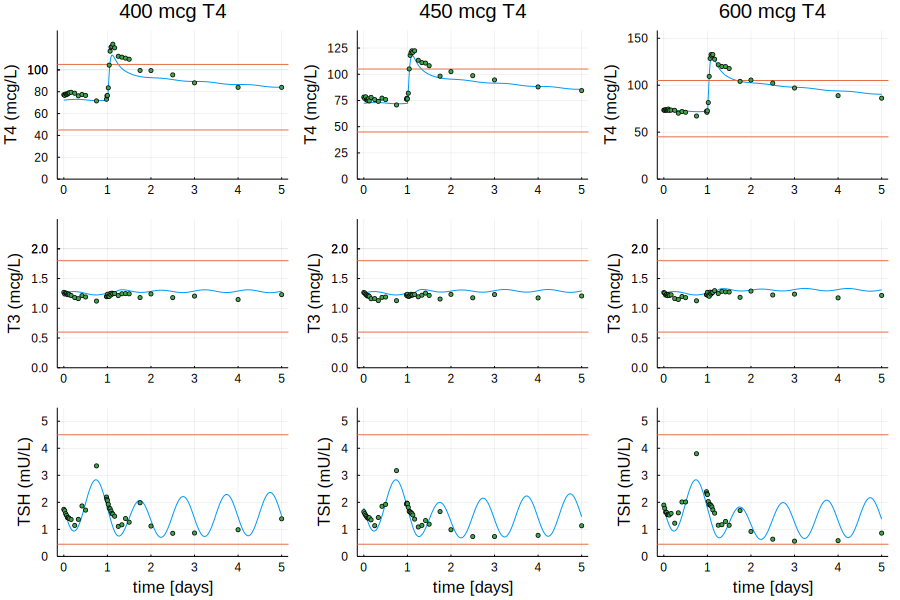

In [68]:
sex = false # 1 = male, 0 = female
bmi = train_minimizer[findfirst(x -> x == (sex ? 65 : 66), fitting_index)]
h = train_minimizer[findfirst(x -> x == (sex ? 78 : 79), fitting_index)]
w = bmi * h^2
println("h = $h, w = $w")
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode,
    scale_allometric_exponent=scale_allometric_exponent,scale_clearance_by_gender=scale_clearance_by_gender) 
p[fitting_index] .= train_minimizer

#400 T4
# T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
# T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
# find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
# T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
# find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

In [69]:
savefig(blakesley_plot, dir * "blakesley_plot.svg")

## Jonklaas data (T3 data)
overweight patients are those with BMI > 30.

In [88]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex),
            fitting_index=fitting_index, p_being_optimized=train_minimizer,
            scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
            scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
            scale_clearance_by_gender=scale_clearance_by_gender) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = train_minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute standard error of the mean
    normal_45_T4_std = std.(normal_45_T4) ./ sqrt(3)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3) ./ sqrt(3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH) ./ sqrt(3)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4) ./ sqrt(6)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3) ./ sqrt(6)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH) ./ sqrt(6)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4) ./ sqrt(4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3) ./ sqrt(4)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) ./ sqrt(4) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4) ./ sqrt(2)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3) ./ sqrt(2)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH) ./ sqrt(2); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # data's mean and std (of the mean)
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2) ./ sqrt(3)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2) ./ sqrt(6)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2) ./ sqrt(4)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2) ./ sqrt(2);

    Plots.scalefontsizes(1.5)

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal hypothyroid patient 45 mcg (n = 3)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal hypothyroid patient 30 mcg (n = 6)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight hypothyroid patient 45 mcg (n = 4)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight hypothyroid patient 30 mcg (n = 2)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()

LoadError: [91mDimensionMismatch("array could not be broadcast to match destination")[39m

In [13]:
savefig(combine, "jonklaas_fig.svg")

# Fat free mass by gender and height

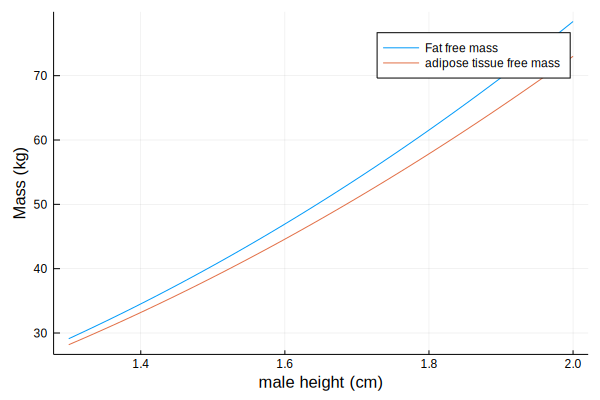

In [89]:
sex = true # male
h = 1.3:0.01:2 #meter
ffm_male = fat_free_mass.(sex, h)
atfm_male = adipose_tissue_free_mass.(sex, h)
plot(h, [ffm_male atfm_male], xlabel="male height (cm)", ylabel="Mass (kg)",
    label=["Fat free mass" "adipose tissue free mass"])

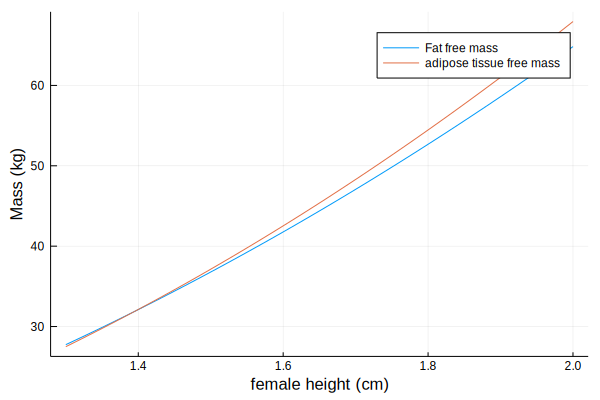

In [90]:
sex = false # female
h = 1.3:0.01:2 #meter
ffm_female = fat_free_mass.(sex, h)
atfm_female = adipose_tissue_free_mass.(sex, h)
plot(h, [ffm_female atfm_female], xlabel="female height (cm)", ylabel="Mass (kg)",
    label=["Fat free mass" "adipose tissue free mass"])

# New Jonklaas plots

In [70]:
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
# simulate jonklaas patient over 16 weeks, interpolating weights weekly, returning T4/T3/TSH values
function simulate_one_jonklaas_patient_new(
    patient_idx::Int,
    result_minimzer::Vector, # first n elem is parameters, n+1:end is T4/T3 secrete rates
    fitting_index::Vector, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    jonklaas_secrete_rate_clusters::Vector;
    verbose::Bool = true,
    scale_plasma_ode::Bool = false,
    scale_slow_ode::Bool = false,
    scale_fast_ode::Bool = false,
    scale_allometric_exponent::Bool = false,
    scale_clearance_by_gender::Bool = false,
    )
    
    # return vectors
    Vp = Float64[]
    T4 = Float64[]
    T3 = Float64[]
    TSH = Float64[]
    times = Float64[]
    
    # other parameters
    dial = [1.0; 0.88; 1.0; 0.88]
    nsamples = size(jonklaas_patient_param, 1)
    cbk = PeriodicCallback(add_dose!, 24) 
    weight_w1 = jonklaas_patient_param[:, 1] # week 1 weight
    height = jonklaas_patient_param[:, 3]
    sex = convert(BitVector, jonklaas_patient_param[:, 4])
    secretion_rates = @view(result_minimzer[length(fitting_index)+1:end])
    
    # run model to steady state before actual simulation
#     cluster = jonklaas_secrete_rate_clusters[patient_idx]
#     dial[1] = secretion_rates[2cluster - 1]
#     dial[3] = secretion_rates[2cluster]
    dial[1] = dial[3] = 1.0
    sol = simulate(height[patient_idx], weight_w1[patient_idx], sex[patient_idx], days=50, dial=dial, 
        warmup=false, fitting_index=fitting_index, parameters=result_minimzer[1:length(fitting_index)],
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    _, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx], sex[patient_idx],
        fitting_index=fitting_index, p_being_optimized=result_minimzer,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    
    # run first 8 week simulations, interpolate weight weekly
    weight_diff = (jonklaas_patient_param[patient_idx, 2] - jonklaas_patient_param[patient_idx, 1]) / 16.0
    dial[1] = dial[3] = 0.0
    for week in 1:8
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx], fitting_index=fitting_index, p_being_optimized=train_minimizer,
            scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
            scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
            scale_clearance_by_gender=scale_clearance_by_gender)
        p[55] = jonklaas_patient_dose[patient_idx, 1] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = week == 1 ? 777.0 * sol[1, :] / p[47] : vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = week == 1 ? 651.0 * sol[4, :] / p[47] : vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = week == 1 ? 5.6 * sol[7, :] / p[48] : vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = week == 1 ? sol.t : vcat(times, sol.t[2:end] .+ times[end])
        push!(Vp, p[47])
    end

    # run next 8 week, interpolate weight weekly
    verbose && println("week 1-8  dose = ", jonklaas_patient_dose[patient_idx, 1])
    verbose && println("week 9-16 dose = ", jonklaas_patient_dose[patient_idx, 2])

    for week in 9:16
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx], fitting_index=fitting_index, p_being_optimized=train_minimizer,
                
            scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
            scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
            scale_clearance_by_gender=scale_clearance_by_gender)
        p[55] = jonklaas_patient_dose[patient_idx, 2] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = vcat(times, sol.t[2:end] .+ times[end])
        push!(Vp, p[47])
    end
    
    return T4, T3, TSH, times, Vp
end

"""
Converts TT4 (μmol) to FT4 (μmol) using Thyrosim's internal 4th order polynomial
"""
function FT4(TT4::Float64)
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4^2) - (8.83e-6 * TT4^3)) * TT4
end

"""
Converts TT4 (μmol, Thyrosim output q1) to FT4 (ng/dL, jonklaas's units) 
"""
function TT4_to_FT4(TT4::Float64, Vp::Float64)
    return FT4(TT4) * 777 / Vp * 1000 * 0.4 / 10
end

function plot_jonklaas_new(
    patient_idx::Int,
    jonklaas_patient_param::Matrix, 
    T4::Vector,    # simulated T4
    T3::Vector,    # simulated T3
    TSH::Vector,   # simulated TSH
    times::Vector, # time intervals (units = days)
    FT4data::Matrix,   # data
    T3data::Matrix,    # data
    TSHdata::Matrix;   # data
    title::AbstractString="Thyrosim simulation (Jonklaas new data)",
    automargins::Bool=true,
    )

    markersize = 2
    
    # get plasma volume for 3 time points to calculate TT4
    sex = Bool(jonklaas_patient_param[patient_idx, 4])
    height = jonklaas_patient_param[patient_idx, 3]
    weight_w1 = jonklaas_patient_param[patient_idx, 1]
    Vb = Thyrosim.blood_volume(height, weight_w1, sex) # use blood volume instead of Vp??
    Vp, _ = Thyrosim.plasma_volume(height, weight_w1, sex)
    
    # get predicted T4 (need to convert μmol to μg/L)
    t_data = [0.0, 56, 112] # 8 and 16 weeks
#     T4data = [FT4_to_TT4(FT4data[patient_idx, 2], Vb) * 777 / Vp, 
#               FT4_to_TT4(FT4data[patient_idx, 3], Vb) * 777 / Vp, 
#               FT4_to_TT4(FT4data[patient_idx, 4], Vb) * 777 / Vp]
    
    # parameters to adjust figure limits
    t4lim, t3lim, tshlim = 140, 4, 10
    if automargins
        t4lim = max(1.2maximum(T4), 110.0)# , 1.2T4data...)
        t3lim = max(1.2maximum(T3), 2.5, 1.2T3data[patient_idx, :]...)
        tshlim = max(1.2maximum(TSH), 5.5, 1.2TSHdata[patient_idx, :]...)
    end

    p1 = plot(times, T4, ylim=(0, t4lim), label="",ylabel="T4 (mcg/L)", title=title)
    hline!([45, 105], label= "")
#     scatter!(p1, t_data, T4data, label="", markersize=markersize)

    p2 = plot(times, T3, ylim=(0, t3lim), label="", ylabel="T3 (mcg/L)")
    hline!([0.6, 1.8], label= "")
    scatter!(p2, t_data, T3data[patient_idx, 2:4], label="", markersize=markersize)

    p3 = plot(times, TSH, ylim=(0, tshlim), label="", ylabel="TSH (mU/L)", xlabel="time [days]")
    hline!([0.45, 4.5], label= "")
    scatter!(p3, t_data, TSHdata[patient_idx, 2:4], label="", markersize=markersize)

    plot(p1, p2, p3, layout=(3, 1))
end

function summarize_fit(
    train_minimizer::AbstractVector{Float64},
    fitting_index::AbstractVector{Int};
    sex::Int = -1, # 1 = plot male only, 0 = only female, -1 = plot male and female
    BMI::AbstractRange = 1:100,
    scale_allometric_exponent = false,
    scale_plasma_ode = false,
    scale_slow_ode = false,
    scale_fast_ode = false,
    scale_clearance_by_gender = false,
    )
    patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

    T4_data_p1, T4_sim_p1 = Float64[], Float64[]
    T4_data_p2, T4_sim_p2 = Float64[], Float64[]
    T4_data_p3, T4_sim_p3 = Float64[], Float64[]
    T3_data_p1, T3_sim_p1 = Float64[], Float64[]
    T3_data_p2, T3_sim_p2 = Float64[], Float64[]
    T3_data_p3, T3_sim_p3 = Float64[], Float64[]
    TSH_data_p1, TSH_sim_p1 = Float64[], Float64[]
    TSH_data_p2, TSH_sim_p2 = Float64[], Float64[]
    TSH_data_p3, TSH_sim_p3 = Float64[], Float64[]

    num_patients = 0
    for i in 1:size(patient_param, 1)
        # decide if we want to run current patient
        s = jonklaas_patient_param[i, 4]
        sex == 1 && s == 0 && continue
        sex == 0 && s == 1 && continue
        w = jonklaas_patient_param[i, 1] # week 1 weight
        h = jonklaas_patient_param[i, 3] # height
        bmi = w / h^2
        first(BMI) ≤ bmi ≤ last(BMI) || continue
        num_patients += 1
        
        # run simulation
        TT4, T3, TSH, times, Vp = simulate_one_jonklaas_patient_new(i, train_minimizer, fitting_index, 
            jonklaas_patient_param, jonklaas_patient_dose, jonklaas_secrete_rate_clusters,
            scale_allometric_exponent=scale_allometric_exponent,
            scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
            scale_fast_ode=scale_fast_ode, scale_clearance_by_gender=scale_clearance_by_gender, 
            verbose=false)
        p1_time = 1
        p2_time = findfirst(x -> x == 24*7*8, times)
        p3_time = length(times)

        # predicted T4/T3/TSH
        push!(T4_sim_p1, TT4_to_FT4(TT4[p1_time] * Vp[1] / 777, Vp[1]))
        push!(T4_sim_p2, TT4_to_FT4(TT4[p2_time] * Vp[9] / 777, Vp[9]))
        push!(T4_sim_p3, TT4_to_FT4(TT4[p3_time] * Vp[16] / 777, Vp[16]))
        push!(T3_sim_p1, T3[p1_time])
        push!(T3_sim_p2, T3[p2_time])
        push!(T3_sim_p3, T3[p3_time])
        push!(TSH_sim_p1, TSH[p1_time])
        push!(TSH_sim_p2, TSH[p2_time])
        push!(TSH_sim_p3, TSH[p3_time])

        # actual T4/T3/TSH
        T4data_p1, T4data_p2, T4data_p3 = patient_t4[i, 2:4]
        T3data_p1, T3data_p2, T3data_p3 = patient_t3[i, 2:4]
        TSHdata_p1, TSHdata_p2, TSHdata_p3 = patient_tsh[i, 2:4]
        push!(T4_data_p1, T4data_p1)
        push!(T4_data_p2, T4data_p2)
        push!(T4_data_p3, T4data_p3)
        push!(T3_data_p1, T3data_p1)
        push!(T3_data_p2, T3data_p2)
        push!(T3_data_p3, T3data_p3)
        push!(TSH_data_p1, TSHdata_p1)
        push!(TSH_data_p2, TSHdata_p2)
        push!(TSH_data_p3, TSHdata_p3)
    end
    
    println("Number of patients = $num_patients")

#     T4_t1_plt = boxplot(T4_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 1)")
#     boxplot!(T4_t1_plt, T4_data_p1)

#     T4_t2_plt = boxplot(T4_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 2)")
#     boxplot!(T4_t2_plt, T4_data_p2)

#     T4_t3_plt = boxplot(T4_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 3)")
#     boxplot!(T4_t3_plt, T4_data_p3)

    T3_t1_plt = boxplot(T3_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 1, n = $num_patients)", ylim=(0.5, 2.0))
    boxplot!(T3_t1_plt, T3_data_p1)

    T3_t2_plt = boxplot(T3_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 2, n = $num_patients)", ylim=(0.5, 2.0))
    boxplot!(T3_t2_plt, T3_data_p2)

    T3_t3_plt = boxplot(T3_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 3, n = $num_patients)", ylim=(0.5, 2.0))
    boxplot!(T3_t3_plt, T3_data_p3)

    TSH_t1_plt = boxplot(TSH_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 1, n = $num_patients)", ylim=(0.0, 5.0))
    boxplot!(TSH_t1_plt, TSH_data_p1)

    TSH_t2_plt = boxplot(TSH_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 2, n = $num_patients)", ylim=(0.0, 5.0))
    boxplot!(TSH_t2_plt, TSH_data_p2)

    TSH_t3_plt = boxplot(TSH_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 3, n = $num_patients)", ylim=(0.0, 5.0))
    boxplot!(TSH_t3_plt, TSH_data_p3)
    
#     combined = plot(T4_t1_plt, T4_t2_plt, T4_t3_plt,
#         T3_t1_plt, T3_t2_plt, T3_t3_plt,
#         TSH_t1_plt, TSH_t2_plt, TSH_t3_plt,
#         size=(800, 600), layout=(3, 3))
    combined = plot(T3_t1_plt, T3_t2_plt, T3_t3_plt,
        TSH_t1_plt, TSH_t2_plt, TSH_t3_plt,
        size=(800, 600), layout=(2, 3))
    return combined, TSH_sim_p1, TSH_sim_p2, TSH_sim_p3, TSH_data_p1, TSH_data_p2, TSH_data_p3, 
        T3_sim_p1, T3_sim_p2, T3_sim_p3, T3_data_p1, T3_data_p2, T3_data_p3, 
        T4_sim_p1, T4_sim_p2, T4_sim_p3, T4_data_p1, T4_data_p2, T4_data_p3
end

summarize_fit (generic function with 1 method)

# Problem diagnostic

In [71]:
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()
jonklaas_secrete_rate_clusters = [4,2,2,1,3,1,3,1,2,1,2,4,1,2,1,3,1,2,3,1,3,4,4,1,1,3,4,1,1,1,2,1,1];

tsh_end = patient_tsh[:, 4]
tsh_1 = patient_tsh[:, 1]
t3_end = patient_t3[:, 4]
bmi = jonklaas_patient_param[:, 1] ./ jonklaas_patient_param[:, 3].^2
dose_per_kg = jonklaas_patient_dose[:, 2] ./ jonklaas_patient_param[:, 2]
height = jonklaas_patient_param[:, 3]
weight = jonklaas_patient_param[:, 2]
sex_idx = convert(BitVector, jonklaas_patient_param[:, 4])
postfit, pred_tsh1, pred_tsh2, pred_tsh3, data_tsh1, data_tsh2, data_tsh3,
    pred_t3_1, pred_t3_2, pred_t3_3, data_t3_1, data_t3_2, data_t3_3, 
    pred_t4_1, pred_t4_2, pred_t4_3, data_t4_1, data_t4_2, data_t4_3 = 
    summarize_fit(train_minimizer, fitting_index, scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender);

Number of patients = 50


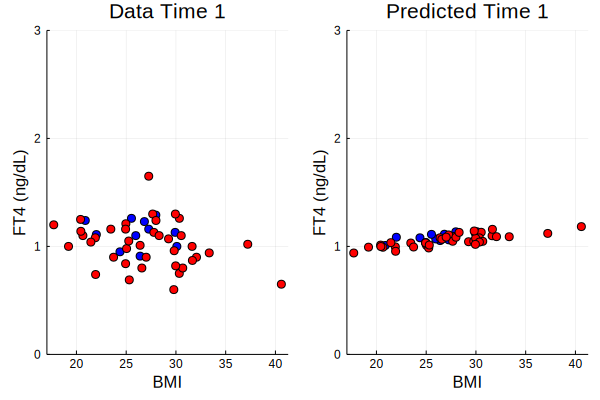

In [72]:
p1 = scatter(bmi[sex_idx], data_t4_1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 1", legend=:none)
scatter!(p1, bmi[.!sex_idx], data_t4_1[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 1")
p2 = scatter(bmi[sex_idx], pred_t4_1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 1", legend=:none)
scatter!(p2, bmi[.!sex_idx], pred_t4_1[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 1")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_FT4_compare_time1.svg")

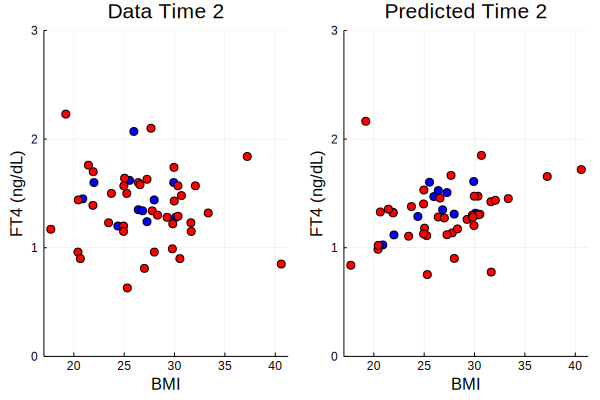

In [73]:
p1 = scatter(bmi[sex_idx], data_t4_2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 2", legend=:none)
scatter!(p1, bmi[.!sex_idx], data_t4_2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 2")
p2 = scatter(bmi[sex_idx], pred_t4_2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 2", legend=:none)
scatter!(p2, bmi[.!sex_idx], pred_t4_2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 2")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_FT4_compare_time2.svg")

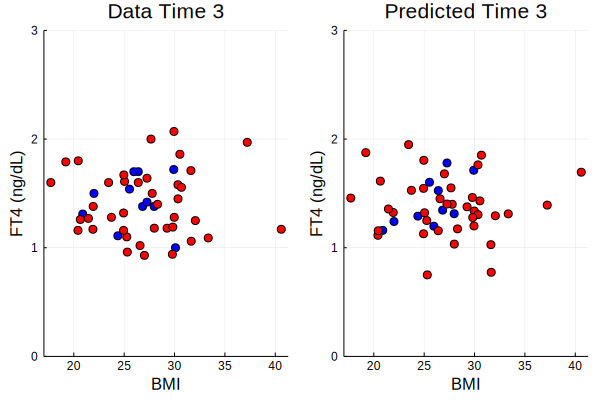

In [74]:
p1 = scatter(bmi[sex_idx], data_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 3", legend=:none)
scatter!(p1, bmi[.!sex_idx], data_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Data Time 3")
p2 = scatter(bmi[sex_idx], pred_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 3", legend=:none)
scatter!(p2, bmi[.!sex_idx], pred_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="FT4 (ng/dL)", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_FT4_compare_time3.svg")

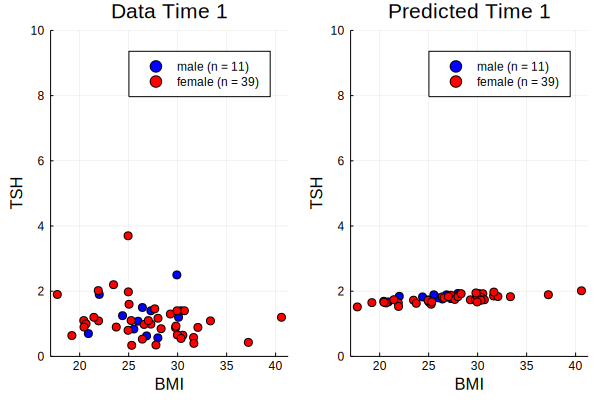

In [75]:
p1 = scatter(bmi[sex_idx], data_tsh1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 1")
scatter!(p1, bmi[.!sex_idx], data_tsh1[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 1")
p2 = scatter(bmi[sex_idx], pred_tsh1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 1")
scatter!(p2, bmi[.!sex_idx], pred_tsh1[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 1")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_TSH_compare_time1.svg")

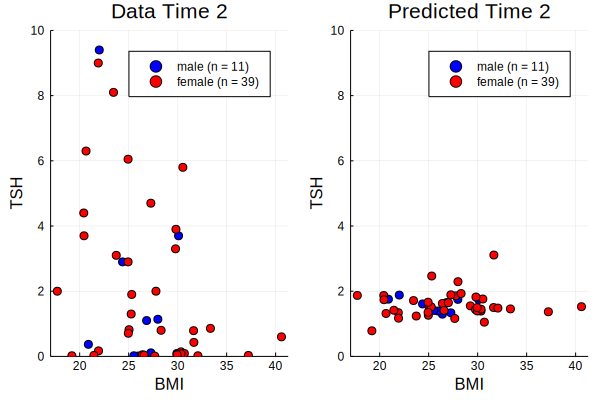

In [76]:
p1 = scatter(bmi[sex_idx], data_tsh2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 2")
scatter!(p1, bmi[.!sex_idx], data_tsh2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 2")
p2 = scatter(bmi[sex_idx], pred_tsh2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 2")
scatter!(p2, bmi[.!sex_idx], pred_tsh2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 2")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_TSH_compare_time2.svg")

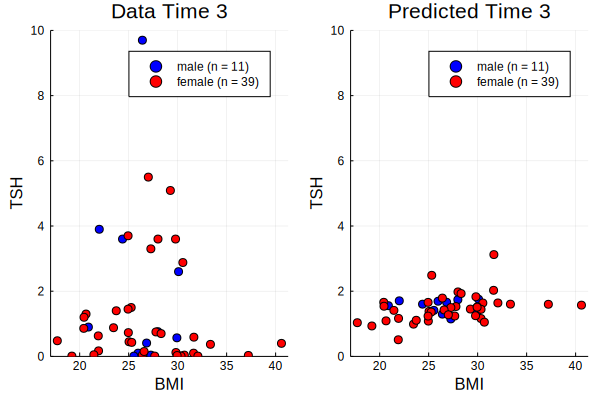

In [77]:
p1 = scatter(bmi[sex_idx], data_tsh3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 3")
scatter!(p1, bmi[.!sex_idx], data_tsh3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Data Time 3")
p2 = scatter(bmi[sex_idx], pred_tsh3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 3")
scatter!(p2, bmi[.!sex_idx], pred_tsh3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 10), xlabel="BMI",
    ylabel="TSH", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_TSH_compare_time3.svg")

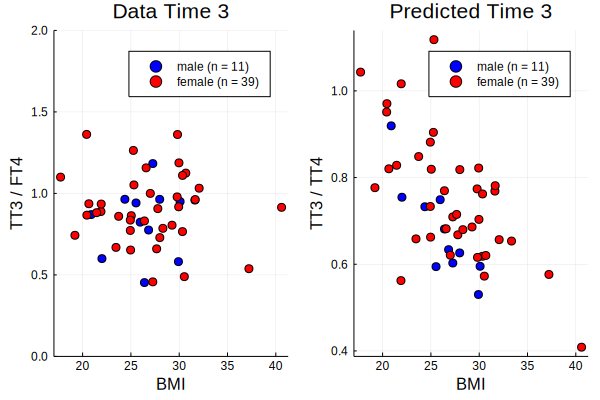

In [78]:
p1 = scatter(bmi[sex_idx], data_t3_3[sex_idx] ./ data_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 2), xlabel="BMI",
    ylabel="TT3 / FT4", title="Data Time 3")
scatter!(p1, bmi[.!sex_idx], data_t3_3[.!sex_idx] ./ data_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 2), xlabel="BMI",
    ylabel="TT3 / FT4", title="Data Time 3")
p2 = scatter(bmi[sex_idx], pred_t3_3[sex_idx] ./ pred_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", xlabel="BMI",
    ylabel="TT3 / FT4", title="Predicted Time 3")
scatter!(p2, bmi[.!sex_idx], pred_t3_3[.!sex_idx] ./ pred_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", xlabel="BMI",
    ylabel="TT3 / TT4", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3T4_BMI_time3.svg")

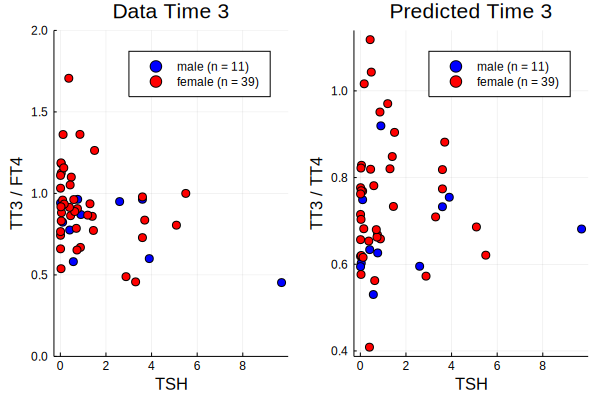

In [79]:
p1 = scatter(data_tsh3[sex_idx], data_t3_3[sex_idx] ./ data_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 2), xlabel="TSH",
    ylabel="TT3 / FT4", title="Data Time 3")
scatter!(p1, data_tsh3[.!sex_idx], data_t3_3[.!sex_idx] ./ data_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 2), xlabel="TSH",
    ylabel="TT3 / FT4", title="Data Time 3")
p2 = scatter(data_tsh3[sex_idx], pred_t3_3[sex_idx] ./ pred_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", xlabel="TSH",
    ylabel="TT3 / FT4", title="Predicted Time 3")
scatter!(p2, data_tsh3[.!sex_idx], pred_t3_3[.!sex_idx] ./ pred_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", xlabel="TSH",
    ylabel="TT3 / TT4", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3T4_TSH_time3.svg")

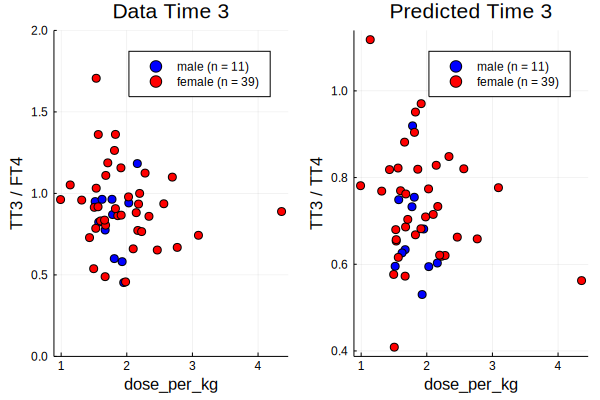

In [80]:
p1 = scatter(dose_per_kg[sex_idx], data_t3_3[sex_idx] ./ data_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 2), xlabel="dose_per_kg",
    ylabel="TT3 / FT4", title="Data Time 3")
scatter!(p1, dose_per_kg[.!sex_idx], data_t3_3[.!sex_idx] ./ data_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 2), xlabel="dose_per_kg",
    ylabel="TT3 / FT4", title="Data Time 3")
p2 = scatter(dose_per_kg[sex_idx], pred_t3_3[sex_idx] ./ pred_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", xlabel="dose_per_kg",
    ylabel="TT3 / FT4", title="Predicted Time 3")
scatter!(p2, dose_per_kg[.!sex_idx], pred_t3_3[.!sex_idx] ./ pred_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", xlabel="dose_per_kg",
    ylabel="TT3 / TT4", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3T4_dosePerKG_time3.svg")

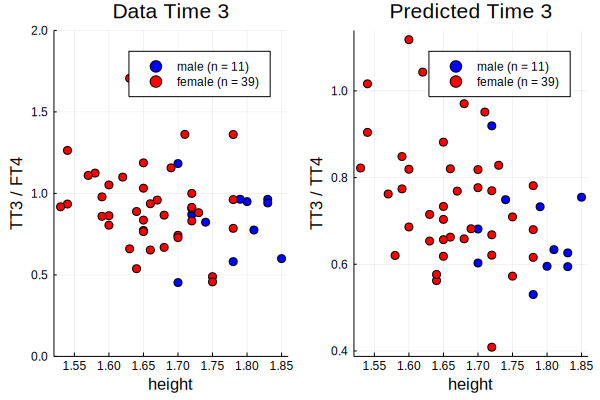

In [81]:
p1 = scatter(height[sex_idx], data_t3_3[sex_idx] ./ data_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 2), xlabel="height",
    ylabel="TT3 / FT4", title="Data Time 3")
scatter!(p1, height[.!sex_idx], data_t3_3[.!sex_idx] ./ data_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 2), xlabel="height",
    ylabel="TT3 / FT4", title="Data Time 3")
p2 = scatter(height[sex_idx], pred_t3_3[sex_idx] ./ pred_t4_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", xlabel="height",
    ylabel="TT3 / FT4", title="Predicted Time 3")
scatter!(p2, height[.!sex_idx], pred_t3_3[.!sex_idx] ./ pred_t4_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", xlabel="height",
    ylabel="TT3 / TT4", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3T4_height_time3.svg")

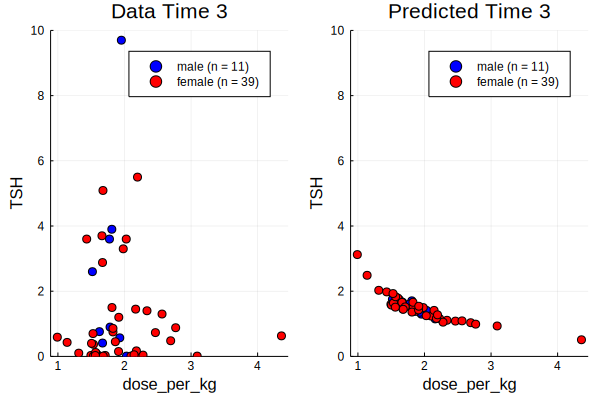

In [82]:
p1 = scatter(dose_per_kg[sex_idx], data_tsh3[sex_idx], color = "blue", label="male (n = $(length(dose_per_kg[sex_idx])))", ylim=(0, 10), xlabel="dose_per_kg",
    ylabel="TSH", title="Data Time 3")
scatter!(p1, dose_per_kg[.!sex_idx], data_tsh3[.!sex_idx], color = "red", label="female (n = $(length(dose_per_kg[.!sex_idx])))", ylim=(0, 10), xlabel="dose_per_kg",
    ylabel="TSH", title="Data Time 3")
p2 = scatter(dose_per_kg[sex_idx], pred_tsh3[sex_idx], color = "blue", label="male (n = $(length(dose_per_kg[sex_idx])))", ylim=(0, 10), xlabel="dose_per_kg",
    ylabel="TSH", title="Predicted Time 3")
scatter!(p2, dose_per_kg[.!sex_idx], pred_tsh3[.!sex_idx], color = "red", label="female (n = $(length(dose_per_kg[.!sex_idx])))", ylim=(0, 10), xlabel="dose_per_kg",
    ylabel="TSH", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_TSH_dosePerKG_time3.svg")

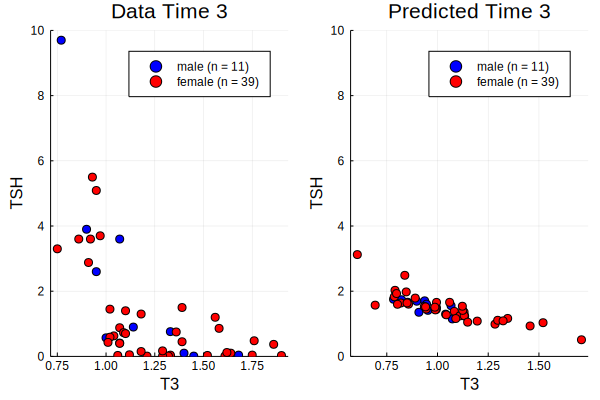

In [83]:
p1 = scatter(data_t3_3[sex_idx], data_tsh3[sex_idx], color = "blue", label="male (n = $(length(data_t3_3[sex_idx])))", ylim=(0, 10), xlabel="T3",
    ylabel="TSH", title="Data Time 3")
scatter!(p1, data_t3_3[.!sex_idx], data_tsh3[.!sex_idx], color = "red", label="female (n = $(length(data_t3_3[.!sex_idx])))", ylim=(0, 10), xlabel="T3",
    ylabel="TSH", title="Data Time 3")
p2 = scatter(pred_t3_3[sex_idx], pred_tsh3[sex_idx], color = "blue", label="male (n = $(length(data_t3_3[sex_idx])))", ylim=(0, 10), xlabel="T3",
    ylabel="TSH", title="Predicted Time 3")
scatter!(p2, pred_t3_3[.!sex_idx], pred_tsh3[.!sex_idx], color = "red", label="female (n = $(length(data_t3_3[.!sex_idx])))", ylim=(0, 10), xlabel="T3",
    ylabel="TSH", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_TSH_T3_time3.svg")

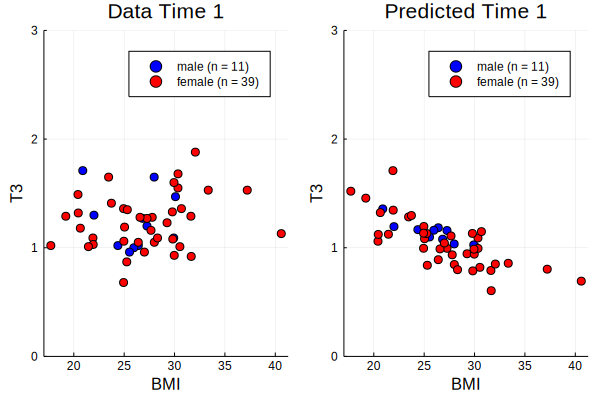

In [84]:
p1 = scatter(bmi[sex_idx], data_t3_1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 1")
scatter!(p1, bmi[.!sex_idx], data_t3_1[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 1")
p2 = scatter(bmi[sex_idx], pred_t3_1[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 1")
scatter!(p2, bmi[.!sex_idx], pred_t3_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 1")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3_BMI_time1.svg")

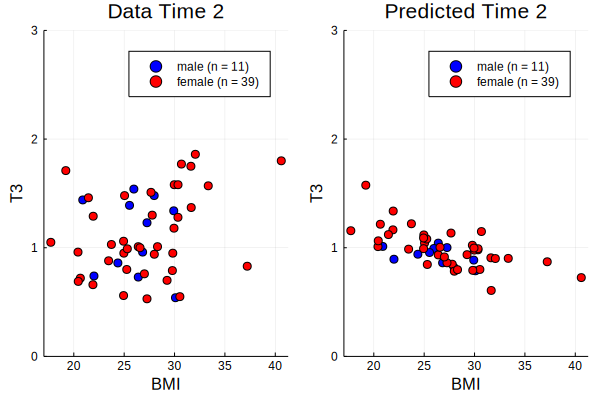

In [85]:
p1 = scatter(bmi[sex_idx], data_t3_2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 2")
scatter!(p1, bmi[.!sex_idx], data_t3_2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 2")
p2 = scatter(bmi[sex_idx], pred_t3_2[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 2")
scatter!(p2, bmi[.!sex_idx], pred_t3_2[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 2")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3_BMI_time2.svg")

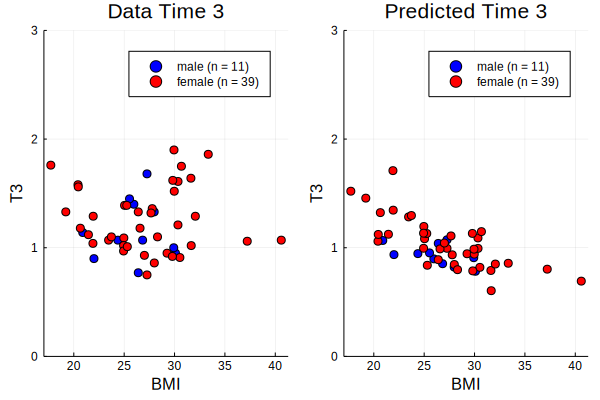

In [86]:
p1 = scatter(bmi[sex_idx], data_t3_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 3")
scatter!(p1, bmi[.!sex_idx], data_t3_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Data Time 3")
p2 = scatter(bmi[sex_idx], pred_t3_3[sex_idx], color = "blue", label="male (n = $(length(bmi[sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 3")
scatter!(p2, bmi[.!sex_idx], pred_t3_3[.!sex_idx], color = "red", label="female (n = $(length(bmi[.!sex_idx])))", ylim=(0, 3), xlabel="BMI",
    ylabel="T3", title="Predicted Time 3")
plt = plot(p1, p2)
display(plt)
savefig(plt, dir * "jonklaas_T3_BMI_time3.svg")

### T4

+ jonklaas FT4 = ng/dL
+ Thyrosim T4 units = mcg/L

According to Simon, we have
$$FT4 (ng/L) = FT4 (mols) * 777/Vp * 1000 * 0.45$$
$$FT3 (ng/L) = FT3 (mols) * 651/Vp * 1000 * 0.50$$

where the FT4 on the right is the 4th order polynomial in Thyrosim's internal equations. Thyrosim outputs TT4 $(\mu mol)$ in $q1$, which we will plug into the polynomial to get $FT4 (\mu mol)$. Then we convert that to Jonklaas's units $FT4 (ng/dL)$. Finally, to get ng/dL, we have
$$\frac{1ng}{dL} = \frac{1 ng}{L} * \frac{L}{10 dL} = \frac{1}{10} \frac{ng}{dL}$$

# Schneider plots

For each patient, we test various T4 doses (in intervals of 12.5 mcg) to see if they normalize TSH values, then compare it to data.

## Possible doses

We will test T4 doses from 62.5, 75 ... all the way to 325 mcg. The smallest and largest doses that achieve euthyroidism (i.e. $0.5 \le$ TSH in last day $\le 4.5$) will be used as the **predicted dosage**. 

+ min/max weight = 38.1/206.4 KG 
+ using 1.6 of T4 per KG -> 61 ~ 330 mcg of T4
+ So test dosages = 50 ~ 337.5 with 12.5 as increments

In [87]:
# helper functions
function find_doses(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    cbk, # call back function
    p,   # parameter vector
    ic;  # initial condition
    tsh_only::Bool = true,
    verbose::Bool=false
    )
    
    possible_doses = 50.0:12.5:325.0
    mindose = 0.0
    maxdose = 0.0
    
    # check doses from bottom up
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss  = TSH_within_interval(sol, p[48])
        else
            loss  = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        if verbose
            t4  = sol.u[end][1] * 777.0 / p[47]
            tsh = sol.u[end][2] * 5.6 / p[48]
            println("    t4 = $t4, tsh = $tsh when dose/kg = $(dose/weight)")
        end
        
        # save doses that work
        if loss == 1
            mindose = dose
            break
        end
    end
    if mindose == 0
        mindose = Inf
    end
    
    # check doses from top to bottom
    for dose in Iterators.reverse(possible_doses)
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss = TSH_within_interval(sol, p[48])
        else
            loss = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        # save doses that work
        if loss == 1
            maxdose = dose
            break
        end
    end
    if maxdose == 0 
        maxdose = Inf
    end
    
    return maxdose, mindose
end

function TSH_within_interval(sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end

function TSH_and_T4_within_interval(sol, Vtsh, Vp)
    tot_loss = 0
    t4  = sol.u[end][1] * 777.0 / Vp
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if (0.5 ≤ tsh ≤ 4.5) && (45 ≤ t4 ≤ 105)
        return true
    end
    return false
end
function find_all_doses(train_data, train_minimizer, fitting_index; 
    tsh_only::Bool=true, verbose=false)
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # define vector of possible doses
    min_predicted_doses = zeros(size(train_data, 1))
    max_predicted_doses = zeros(size(train_data, 1))
    
    # model setup
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    
    # loop over each patient
    pmeter = Progress(size(train_data, 1))
    Threads.@threads for i in 1:size(train_data, 1)
        cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        ic, p = initialize(dial, scale_Vp, h, w, s, fitting_index=fitting_index, 
            p_being_optimized=train_minimizer,
            scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
            scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
            scale_clearance_by_gender=scale_clearance_by_gender)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]

        # find dose
        verbose && println("sample $i, sex = $s, bmi = $(w/h^2): ")
        (maxdose, mindose) = find_doses(h, w, s, cbk, p, ic, tsh_only=tsh_only,verbose=verbose)
        min_predicted_doses[i] = mindose
        max_predicted_doses[i] = maxdose
        next!(pmeter)
    end
    
    return max_predicted_doses, min_predicted_doses
end

find_all_doses (generic function with 1 method)

In [111]:
function find_all_doses_new(train_data, train_minimizer, fitting_index; 
    tsh_only::Bool=false, t4_only::Bool=false, t3_only::Bool=false, verbose=false, 
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=false, scale_clearance_by_gender=false,
    )
    tsh_only && t4_only && error("tsh_only == t4_only == true")
    tsh_only && t3_only && error("tsh_only == t3_only == true")
    t4_only && t3_only && error("t4_only == t3_only == true")
    
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
    init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
    
    # define return vectors
    predicted_doses = zeros(size(train_data, 1))
    predicted_t4 = zeros(size(train_data, 1))
    predicted_t3 = zeros(size(train_data, 1))
    predicted_tsh = zeros(size(train_data, 1))
    
    # model setup
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    
    # loop over each patient
    pmeter = Progress(size(train_data, 1))
    Threads.@threads for i in 1:size(train_data, 1)        
        cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
        w     = weight[i]
        h     = height[i]
        s     = !Bool(sex[i]) # in thyrosim, male is true female is false
        ic, p = initialize(dial, scale_Vp, h, w, s, fitting_index=fitting_index, 
            p_being_optimized=train_minimizer, scale_plasma_ode=scale_plasma_ode,
            scale_slow_ode=scale_slow_ode, scale_fast_ode=scale_fast_ode, 
            scale_allometric_exponent=scale_allometric_exponent,
            scale_clearance_by_gender=scale_clearance_by_gender)
        p[fitting_index] = train_minimizer
        ismissing(init_tsh[i]) ? continue : (ic[7] = init_tsh[i])

        # find dose
        best_dose, best_t4, best_t3, best_tsh = find_best_dose(h, w, s, cbk, p, ic, 
            tsh_only=tsh_only, t4_only=t4_only, t3_only=t3_only, verbose=verbose)
        predicted_doses[i] = best_dose
        predicted_t4[i] = best_t4
        predicted_t3[i] = best_t3
        predicted_tsh[i] = best_tsh
        next!(pmeter)
    end
    
    return predicted_doses, predicted_t4, predicted_t3, predicted_tsh
end

function find_best_dose(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    cbk, # call back function
    p,   # parameter vector
    ic;  # initial condition
    tsh_only::Bool = false,
    t4_only::Bool = false,
    t3_only::Bool = false,
    verbose::Bool = false
    )
    
    possible_doses = 50.0:12.5:325.0
    best_dose = 0.0
    best_err = Inf
    best_t4 = 0.0
    best_t3 = 0.0
    best_tsh = 0.0
    
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 4, 7])

        # calculate average T4/TSH in last day
        idx = findall(x -> x in [984, 1008], sol.t)
        t4  = mean([sol.u[idx][i][1] for i in 1:length(idx)] .* 777.0 ./ p[47])
        t3  = mean([sol.u[idx][i][2] for i in 1:length(idx)] .* 651.0 ./ p[47])
        tsh = mean([sol.u[idx][i][3] for i in 1:length(idx)] .* 5.6 / p[48])
        if tsh_only
            err = abs(tsh - 1.8) # 1.3 is preop TSH value (should be between 1.5 and 2)
        elseif t4_only
            err = abs(t4 - 80)
        elseif t3_only
            err = abs(t3 - 1.0)
        else
            err = abs(t4 - 75) / 60 + abs(tsh - 1.9) / 4
        end
        verbose && println("bmi = $(weight/height^2), dose = $dose, predicted t4 = $t4, predicted tsh = $tsh")
        if err < best_err
            best_dose = dose
            best_err = err
            best_t3 = t3
            best_t4 = t4
            best_tsh = tsh
        end
    end

    verbose && println("sex = $sex, bmi = $(weight/height^2), best_dose = $(best_dose/weight), best_t4 = $best_t4, best_tsh = $best_tsh")

    return best_dose, best_t4, best_t3, best_tsh
end

find_best_dose (generic function with 1 method)

In [89]:
Threads.nthreads()

8

## Check predicted dose based on TSH or TSH+T4

We find a dose that minimizes the following:

$$\frac{|T4 - 75|}{60} + \frac{|TSH - 2.5|}{4}$$

Note 75 and 2.5 are midpoints of T4 and TSH, and 60 and 4 are the length of the normal range of T4 and TSH. Thus, error are normalized between compartments.

In [90]:
scale_plasma_ode, scale_slow_ode, scale_fast_ode, scale_allometric_exponent, scale_clearance_by_gender

(true, false, false, false, false)

## TSH only

+ TSH midpoint = 1.7 (slight under prediction)
+ TSH midpoint = 1.6

In [91]:
@time predicted_doses, predicted_t4, predicted_t3, predicted_tsh = find_all_doses_new(all_schneider, 
    train_minimizer, fitting_index, tsh_only=true, verbose=false, scale_plasma_ode=scale_plasma_ode,
    scale_slow_ode=scale_slow_ode, scale_fast_ode=scale_fast_ode, 
    scale_allometric_exponent=scale_allometric_exponent,scale_clearance_by_gender=scale_clearance_by_gender);
[predicted_doses predicted_t4 predicted_t3 predicted_tsh]

Progress: 100%|█████████████████████████████████████████| Time: 0:02:23


143.374461 seconds (975.33 M allocations: 70.613 GiB, 12.45% gc time)


598×4 Array{Float64,2}:
 162.5  85.0404  0.705664  1.794
 125.0  78.6471  0.907839  1.73398
  87.5  70.4805  1.15398   1.64918
  75.0  67.6823  1.20957   1.61162
 137.5  82.655   0.761573  1.73711
 100.0  75.6456  0.928053  1.67275
 137.5  83.5873  0.75893   1.70962
 125.0  81.2672  0.74421   1.72674
 112.5  77.5228  0.912574  1.69852
 112.5  75.2895  0.840788  1.81114
 112.5  72.8784  0.904479  1.86806
 112.5  76.7283  0.764654  1.79844
 125.0  80.2352  0.845468  1.71236
   ⋮                       
 162.5  86.9826  0.719475  1.72974
 150.0  82.0183  0.74558   1.82038
 175.0  86.0255  0.602388  1.85904
 100.0  69.1701  0.990108  1.88298
 112.5  74.9854  0.979052  1.75234
 162.5  83.6919  0.804589  1.78811
 125.0  78.4783  0.902341  1.74218
 125.0  77.5892  0.873809  1.786
 137.5  78.558   0.748918  1.87917
 125.0  78.7832  0.912288  1.72742
 137.5  80.0771  0.938442  1.73421
 112.5  73.8153  0.937089  1.81566

In [92]:
writedlm(dir * "schneider_dosage_tshOnly_1.8.txt", predicted_doses)

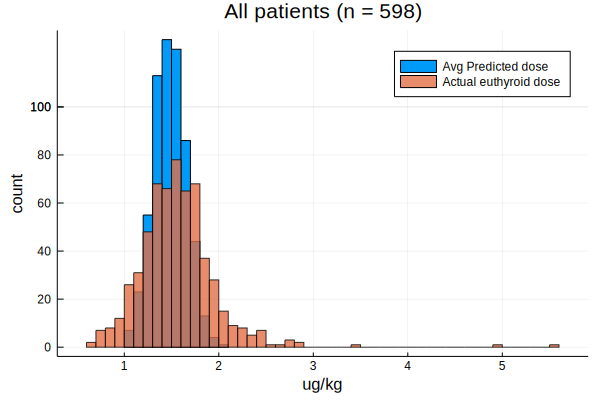

In [95]:
# predicted dose
predicted_t4 = predicted_doses ./ all_schneider[!, Symbol("Wt.kg")]
avgplt_all = histogram(predicted_t4, title="All patients (n = $(length(predicted_t4)))",
    bin=10, xlabel="ug/kg", ylabel="count", label="Avg Predicted dose")

# actual dose
actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
histogram!(avgplt_all, actual_t4, label="Actual euthyroid dose", bin=50, alpha=0.8)

display(avgplt_all)
savefig(avgplt_all, dir * "schneider_dosage_tshOnly_1.8.svg")

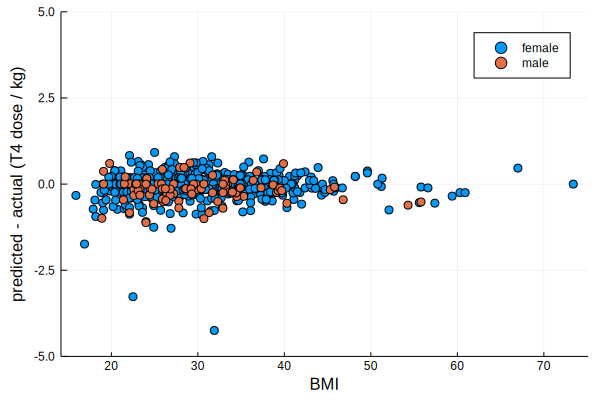

In [94]:
female_idx = findall(all_schneider[!, Symbol("Sex")] .== 1)
male_idx = findall(all_schneider[!, Symbol("Sex")] .== 0)

# female scatter
predicted_t4 = predicted_doses[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
bmi = all_schneider[female_idx, Symbol("BMI")]
plt = scatter(bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual (T4 dose / kg)", 
    label="female", ylim=(-5, 5))

# male scatter
predicted_t4 = predicted_doses[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
bmi = all_schneider[male_idx, Symbol("BMI")]
scatter!(plt, bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual (T4 dose / kg)",
    label="male")

display(plt)
savefig(plt, dir * "schneider_predVSactual_tshOnly_1.8.svg")

## TSH + T4

+ TSH = 1.9 and T4 = 80 will result in most patients needing more dose than they got
+ TSH = 2.5 and T4 = 80 will result in most patients needing more dose than they got
+ TSH = 2.5 and T4 = 75 will result in most patients needing more dose than they got

In [112]:
@time predicted_doses, predicted_t4, predicted_t3, predicted_tsh = find_all_doses_new(all_schneider, 
    train_minimizer, fitting_index, tsh_only=false, verbose=false, scale_plasma_ode=scale_plasma_ode,
    scale_slow_ode=scale_slow_ode, scale_fast_ode=scale_fast_ode, 
    scale_allometric_exponent=scale_allometric_exponent,scale_clearance_by_gender=scale_clearance_by_gender);
[predicted_doses predicted_t4 predicted_t3 predicted_tsh]

Progress: 100%|█████████████████████████████████████████| Time: 0:02:46


166.886383 seconds (974.80 M allocations: 70.585 GiB, 12.48% gc time)


598×4 Array{Float64,2}:
 150.0  79.2707  0.677477  1.9498
 112.5  71.5353  0.859231  1.94612
  87.5  70.4805  1.15398   1.64918
  87.5  77.8267  1.31131   1.35132
 125.0  75.9606  0.724949  1.92195
 100.0  75.6456  0.928053  1.67275
 125.0  76.8382  0.722388  1.89045
 112.5  73.9833  0.704852  1.93298
 112.5  77.5228  0.912574  1.69852
 112.5  75.2895  0.840788  1.81114
 112.5  72.8784  0.904479  1.86806
 112.5  76.7283  0.764654  1.79844
 112.5  73.0189  0.80114   1.91956
   ⋮                       
 137.5  75.0716  0.659907  2.0602
 137.5  75.923   0.712803  1.99676
 150.0  75.076   0.555772  2.18241
 112.5  76.9599  1.05306   1.65034
 112.5  74.9854  0.979052  1.75234
 150.0  77.9882  0.771694  1.94493
 112.5  71.3777  0.854033  1.95551
 125.0  77.5892  0.873809  1.786
 137.5  78.558   0.748918  1.87917
 112.5  71.6624  0.863438  1.93858
 125.0  73.5349  0.892823  1.92324
 112.5  73.8153  0.937089  1.81566

In [113]:
writedlm(dir * "schneider_dosage_T4_75_TSH_1.9.txt", predicted_doses)

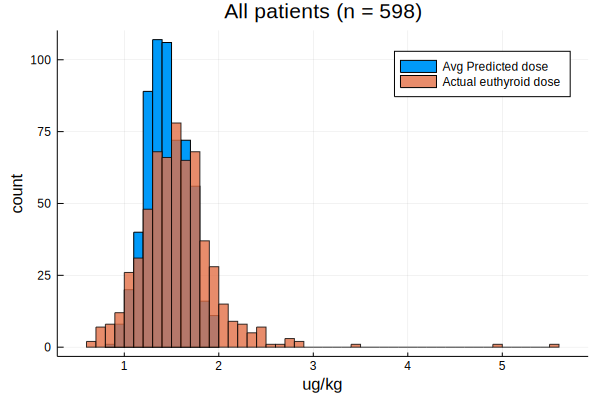

In [114]:
# predicted dose
predicted_t4 = predicted_doses ./ all_schneider[!, Symbol("Wt.kg")]
avgplt_all = histogram(predicted_t4, title="All patients (n = $(length(predicted_t4)))",
    bin=20, xlabel="ug/kg", ylabel="count", label="Avg Predicted dose")

# actual dose
actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
histogram!(avgplt_all, actual_t4, label="Actual euthyroid dose", bin=50, alpha=0.8)

display(avgplt_all)
savefig(avgplt_all, dir * "schneider_dosage_T4_75_TSH_1.9.svg")

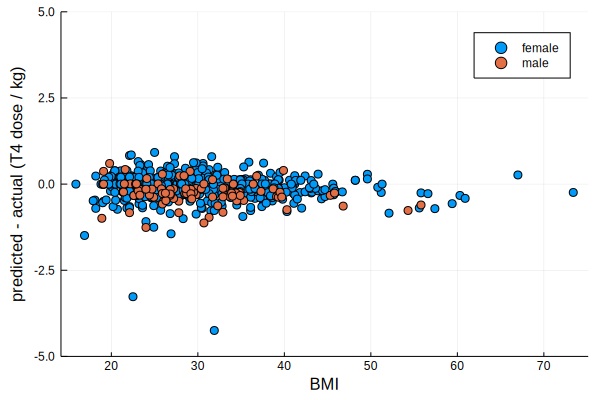

In [115]:
female_idx = findall(all_schneider[!, Symbol("Sex")] .== 1)
male_idx = findall(all_schneider[!, Symbol("Sex")] .== 0)

# female scatter
predicted_t4 = predicted_doses[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
bmi = all_schneider[female_idx, Symbol("BMI")]
plt = scatter(bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual (T4 dose / kg)", 
    label="female", ylim=(-5, 5))

# male scatter
predicted_t4 = predicted_doses[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
bmi = all_schneider[male_idx, Symbol("BMI")]
scatter!(plt, bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual (T4 dose / kg)",
    label="male")

display(plt)
savefig(plt, dir * "schneider_predVSactual_T4_75_TSH_1.9.svg")

# Final dosage prediction plot

In [199]:
function make_plot(predicted_doses, title::AbstractString)
    predicted_t4 = predicted_doses ./ all_schneider[!, Symbol("Wt.kg")]
    
    # overlapping historgrams
    plt1 = histogram(predicted_t4, xlabel="ug/kg", ylabel="count", 
        label="Avg P-T Predicted dose", legendfontsize=6, legend=:topright)
    actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
    histogram!(plt1, actual_t4, label="Actual euthyroid dose", alpha=0.8)
    
    # female scatter
    female_idx = findall(all_schneider[!, Symbol("Sex")] .== 1)
    predicted_t4 = predicted_doses[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
    actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
    bmi = all_schneider[female_idx, Symbol("BMI")]
    plt2 = scatter(bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual dose", 
        label="female", ylim=(-5, 5), legend=:topright)

    # male scatter
    male_idx = findall(all_schneider[!, Symbol("Sex")] .== 0)
    predicted_t4 = predicted_doses[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
    actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
    bmi = all_schneider[male_idx, Symbol("BMI")]
    scatter!(plt2, bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual dose",
        label="male",legendfontsize=6)
    
    plt = plot(title=title, grid = false, showaxis = false, bottom_margin = -40Plots.px)
    
    return plot(plt, plt1, plt2, layout = @layout([A{0.01h}; [B C]]))
end

make_plot (generic function with 1 method)

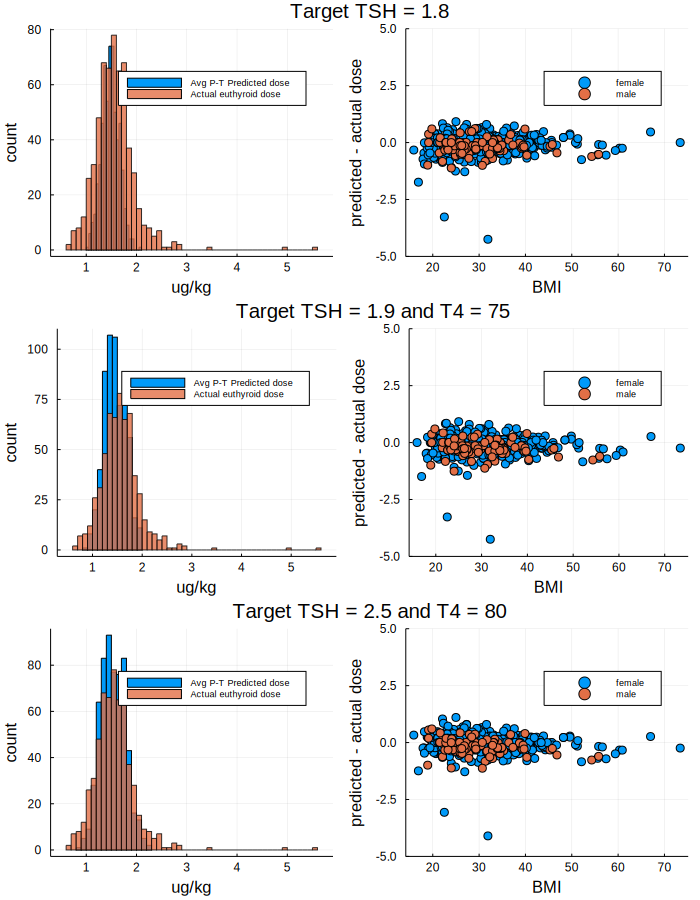

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [116]:
predicted_doses1 = readdlm(dir * "schneider_dosage_tshOnly_1.8.txt")
predicted_doses2 = readdlm(dir * "schneider_dosage_T4_75_TSH_1.9.txt")
predicted_doses3 = readdlm(dir * "schneider_dosage_T4_80_TSH_2.5.txt")

plt1 = make_plot(predicted_doses1, "Target TSH = 1.8")
plt2 = make_plot(predicted_doses2, "Target TSH = 1.9 and T4 = 75")
plt3 = make_plot(predicted_doses3, "Target TSH = 2.5 and T4 = 80")
plt = plot(plt1, plt2, plt3, layout=(3, 1), size=(700, 900))

display(plt)
savefig(plt, dir * "final_schneider_plot.svg")

# Compare with Schneider's result

According to Schneider, 
+ n = 598 patients
+ 504 females
+ median age = 51
+ median weight = 81 kg
+ median BMI = 29.3

These are accuracy given the data we have.

In [57]:
@show size(all_schneider, 1)
@show count(isone, all_schneider[!, Symbol("Sex")])
@show median(all_schneider[!, Symbol("Age")])
@show median(all_schneider[!, Symbol("Wt.kg")])
@show median(all_schneider[!, Symbol("BMI")]);

size(all_schneider, 1) = 598
count(isone, all_schneider[!, Symbol("Sex")]) = 504
median(all_schneider[!, Symbol("Age")]) = 51.0
median(all_schneider[!, Symbol("Wt.kg")]) = 80.7
median(all_schneider[!, Symbol("BMI")]) = 29.25


## 1.6 mcg/kg formula

Schneider defines a "correctly predicted dose" is as within 12.5 mcg of the Euthyroid dose. The 1.6mcg/kg dosing formula should predict

+ 60.9% overall accuracy
+ 64.1% accuracy if BMI $\le 26$ patients
+ 52.8% accuracy if BMI between 27 and 32
+ 38% accuracy if BMI > 32

We cannot reproduce these numbers. 

## Schneider's Poisson formula 

Note his formula needs to multiply by 12.5 at the end. 

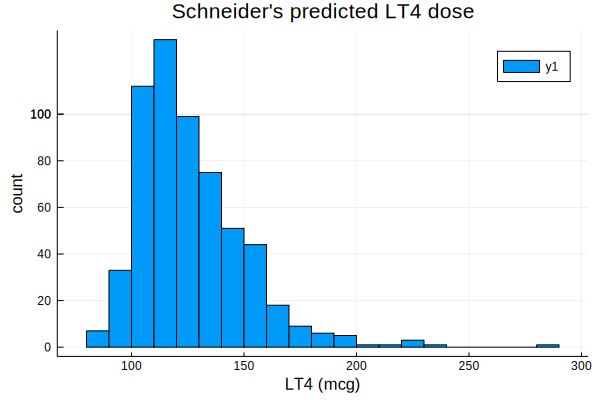

In [100]:
"""
Schneider's Poisson regression formula. Returns daily LTS dose (mcg)

+ weight is in kg
+ female = 1 if sex is female, 0 otherwise
+ preopTSH is measured
+ vitamin and iron supplement = 1 if patients got them, 0 otherwise
"""
function schneider_predict(weight, age, female, bmi, preopTSH, iron_supp, vitamin)
    X = 2.02 + 0.01weight - 0.0037age - 0.098female - 0.01bmi + 0.007preopTSH + 
        0.108iron_supp - 0.014vitamin
    return 12.5*exp(X)
end

weight = all_schneider[!, Symbol("Wt.kg")]
age = all_schneider[!, Symbol("Age")]
isfemale = all_schneider[!, Symbol("Sex")]
bmi = all_schneider[!, Symbol("BMI")]
preopTSH = all_schneider[!, Symbol("TSH.preop")]
iron_supp = all_schneider[!, Symbol("Iron")]
vitamin = all_schneider[!, Symbol("MultiVTM")]

schneider_predicted_dose = [schneider_predict(weight[i], age[i], isfemale[i], bmi[i], preopTSH[i],
    iron_supp[i], vitamin[i]) for i in 1:length(weight)]

plt = histogram(schneider_predicted_dose, title="Schneider's predicted LT4 dose", xlabel="LT4 (mcg)", ylabel="count")
display(plt)
savefig(plt, dir * "schneider_poisson_predicted_dose.svg")

## Papoian vs Thyrosim vs Schneider

In [168]:
predicted_doses = readdlm(dir * "schneider_dosage_tshOnly_1.9.txt") ./ all_schneider[!, Symbol("Wt.kg")]
bmi = all_schneider[!, Symbol("BMI")]
function get_papoian_dose(bmi::Float64)
    if bmi < 25
        return 1.76
    elseif bmi < 30
        return 1.47
    elseif bmi < 35
        return 1.42
    elseif bmi < 40
        return 1.27
    else
        return 1.28
    end
end
papoian_dose = get_papoian_dose.(all_schneider[!, Symbol("BMI")])
plt = histogram(predicted_doses, label="Thyrosim's predicted dose", alpha=0.8, bins=50)
histogram!(plt, papoian_dose, label="Papoian's suggested dose", alpha=0.8, bins=50)

display(plt)
savefig(plt, dir * "dosage_prediction_papoian_vs_tshOnly1.9.svg")

LoadError: [91mArgumentError: Cannot open './scaleCearlance_by_avg/schneider_dosage_tshOnly_1.9.txt': not a file[39m

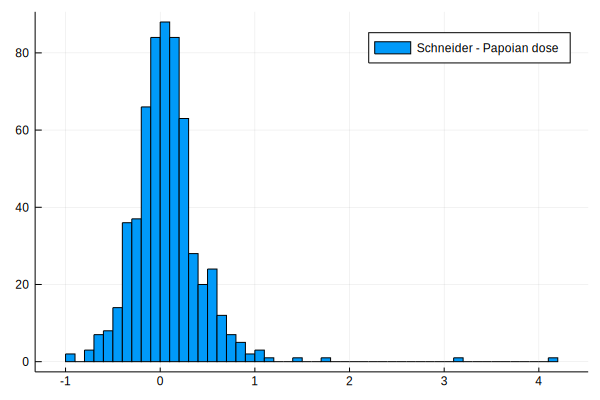

In [169]:
schneider_dose = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
bmi = all_schneider[!, Symbol("BMI")]
papoian_dose = get_papoian_dose.(bmi)
dose_diff = schneider_dose .- papoian_dose
plt = histogram(dose_diff, label="Schneider - Papoian dose")

display(plt)
savefig(plt, dir * "dosage_prediction_Schneider_minus_Papoian.svg")

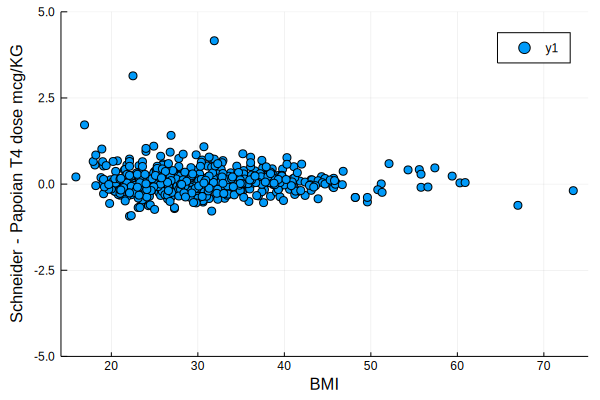

In [170]:
plt = scatter(bmi, dose_diff, xlabel="BMI", ylabel="Schneider - Papoian T4 dose mcg/KG", ylim=(-5, 5))
display(plt)
savefig(plt, dir * "dosage_prediction_Schneider_minus_Papoian_by_BMI.svg")

## Papoian dose vs Schneider vs Thyrosim vs 1.6mcg/kg

In [171]:
papoian_dose = get_papoian_dose.(all_schneider[!, Symbol("BMI")]) .* all_schneider[!, Symbol("Wt.kg")]
[papoian_dose all_schneider[!, Symbol("LT4.euthyroid.dose")]]

598×2 Array{Float64,2}:
 163.584  175.0
 113.337  150.0
  90.288  125.0
  82.192   82.0
 144.272  125.0
 103.092  104.0
 131.84   112.0
 131.318  150.0
 111.279   88.0
 117.292   88.0
 107.31   125.0
 121.031  125.0
 126.714  139.0
   ⋮      
 146.304  125.0
 147.538  150.0
 184.576  150.0
 109.296  125.0
 118.096  137.0
 140.091  175.0
 114.072   75.0
 118.041   88.0
 126.746  150.0
 112.749  112.0
 131.648  125.0
 103.341  116.1

# For Mauricio: tweak figure here

In [196]:
# doses predicted by difference authors
papoian_dose = get_papoian_dose.(all_schneider[!, Symbol("BMI")]) .* all_schneider[!, Symbol("Wt.kg")]
predicted_doses = readdlm(dir * "schneider_dosage_tshOnly_1.8.txt")
# predicted_doses = readdlm(dir * "schneider_dosage_T4_75_TSH_2.5.txt")
weight_dose = 1.6 .* all_schneider[!, Symbol("Wt.kg")]
schneider_predicted_dose = [schneider_predict(weight[i], age[i], isfemale[i], bmi[i], preopTSH[i],
    iron_supp[i], vitamin[i]) for i in 1:length(weight)]

tol = 12.5

# 1.6 mcg/kg vs thyrosim vs papoian overall
cnt = count(x -> -tol ≤ x ≤ tol, weight_dose - all_schneider[!, Symbol("LT4.euthyroid.dose")])
println("1.6 mcg/kg overall accuracy = ", cnt / 598)
papoian_cnt = count(x -> -tol ≤ x ≤ tol, papoian_dose - all_schneider[!, Symbol("LT4.euthyroid.dose")])
println("Papoian overall accuracy = ", papoian_cnt / 598)
Thyrosim_cnt = count(x -> -tol ≤ x ≤ tol, predicted_doses - all_schneider[!, Symbol("LT4.euthyroid.dose")])
println("Thyrosim overall accuracy = ", Thyrosim_cnt / 598)
schneider_cnt = count(x -> -tol ≤ x ≤ tol, schneider_predicted_dose - all_schneider[!, Symbol("LT4.euthyroid.dose")])
println("Schneider overall accuracy = ", schneider_cnt / 598, "\n")

# BMI < 26 should have 64.1 accuracy
idx = findall(x -> x ≤ 26, all_schneider[!, Symbol("BMI")])
cnt = count(x -> -tol ≤ x ≤ tol, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -tol ≤ x ≤ tol, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_cnt = count(x -> -tol ≤ x ≤ tol, papoian_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -tol ≤ x ≤ tol, schneider_predicted_dose[idx] - 
    all_schneider[idx, Symbol("LT4.euthyroid.dose")])
println("Schneider skinny accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg skinny accuracy = ", cnt / length(idx))
println("Papoian skinny accuracy = ", papoian_cnt / length(idx))
println("Thyrosim skinny accuracy = ", Thyrosim_cnt / length(idx), "\n")

# 27 < BMI < 32 should have 52.8 accuracy
idx = findall(x -> 27 ≤ x ≤ 32, all_schneider[!, Symbol("BMI")])
cnt = count(x -> -tol ≤ x ≤ tol, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -tol ≤ x ≤ tol, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_cnt = count(x -> -tol ≤ x ≤ tol, papoian_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -tol ≤ x ≤ tol, schneider_predicted_dose[idx] - all_schneider[idx, 
        Symbol("LT4.euthyroid.dose")])
println("Schneider normal accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg normal accuracy = ", cnt / length(idx))
println("Papoian normal accuracy = ", papoian_cnt / length(idx))
println("Thyrosim normal accuracy = ", Thyrosim_cnt / length(idx), "\n")

# BMI > 32 should have 38% accuracy
idx = findall(x -> x > 32, all_schneider[!, Symbol("BMI")])
cnt = count(x -> -tol ≤ x ≤ tol, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -tol ≤ x ≤ tol, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_cnt = count(x -> -tol ≤ x ≤ tol, papoian_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -tol ≤ x ≤ tol, schneider_predicted_dose[idx] - 
    all_schneider[idx, Symbol("LT4.euthyroid.dose")])
println("Schneider obese accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg obese accuracy = ", cnt / length(idx))
println("Papoian obese accuracy = ", papoian_cnt / length(idx))
println("Thyrosim obese accuracy = ", Thyrosim_cnt / length(idx))

1.6 mcg/kg overall accuracy = 0.3779264214046823
Papoian overall accuracy = 0.42642140468227424
Thyrosim overall accuracy = 0.5100334448160535
Schneider overall accuracy = 0.4397993311036789

Schneider skinny accuracy = 0.5
1.6 mcg/kg skinny accuracy = 0.5194174757281553
Papoian skinny accuracy = 0.5242718446601942
Thyrosim skinny accuracy = 0.6213592233009708

Schneider normal accuracy = 0.4383561643835616
1.6 mcg/kg normal accuracy = 0.3835616438356164
Papoian normal accuracy = 0.410958904109589
Thyrosim normal accuracy = 0.4452054794520548

Schneider obese accuracy = 0.37037037037037035
1.6 mcg/kg obese accuracy = 0.2175925925925926
Papoian obese accuracy = 0.35648148148148145
Thyrosim obese accuracy = 0.44907407407407407


In [194]:
function rmse(x::AbstractVector, y::AbstractVector)
    mse = zero(eltype(x))
    for i in eachindex(x)
        mse += abs2(x[i] - y[i])
    end
    return sqrt(mse / length(x))
end
@show rmse(weight_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")])
@show rmse(papoian_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")])
@show rmse(vec(predicted_doses), all_schneider[!, Symbol("LT4.euthyroid.dose")])
@show rmse(schneider_predicted_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")])

rmse(weight_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")]) = 35.46321887500613
rmse(papoian_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")]) = 32.1040799560234
rmse(vec(predicted_doses), all_schneider[!, Symbol("LT4.euthyroid.dose")]) = 33.25679927966249
rmse(schneider_predicted_dose, all_schneider[!, Symbol("LT4.euthyroid.dose")]) = 30.38827394877009


30.38827394877009

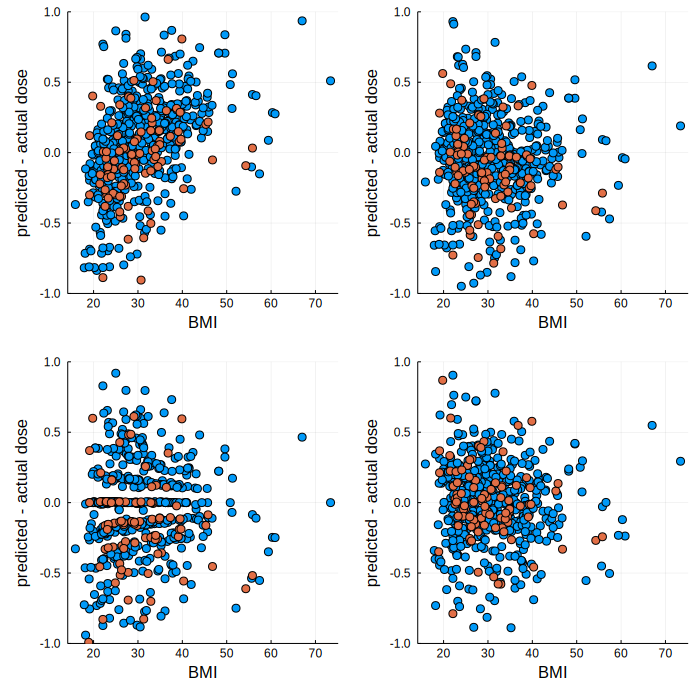

In [207]:
function make_plot(predicted_doses, title::AbstractString)
    predicted_t4 = predicted_doses ./ all_schneider[!, Symbol("Wt.kg")]
    
#     # overlapping historgrams
#     plt1 = histogram(predicted_t4, xlabel="ug/kg", ylabel="count", 
#         label="Avg P-T Predicted dose", legendfontsize=6, legend=:topright)
#     actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
#     histogram!(plt1, actual_t4, label="Actual euthyroid dose", alpha=0.8)
    
    # female scatter
    female_idx = findall(all_schneider[!, Symbol("Sex")] .== 1)
    predicted_t4 = predicted_doses[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
    actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
    bmi = all_schneider[female_idx, Symbol("BMI")]
    plt2 = scatter(bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual dose", 
        label="female", ylim=(-1, 1), legend=:topright)

    # male scatter
    male_idx = findall(all_schneider[!, Symbol("Sex")] .== 0)
    predicted_t4 = predicted_doses[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
    actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
    bmi = all_schneider[male_idx, Symbol("BMI")]
    scatter!(plt2, bmi, predicted_t4 - actual_t4, xlabel="BMI", ylabel="predicted - actual dose",
        label="male",legendfontsize=6,legend=:none)
    
#     return plot(title=title, grid = false, showaxis = false, bottom_margin = -40Plots.px)
#     return plot(plt, plt2, layout = @layout([A{0.01h}; [B C]]))
    return plt2
end
plt1 = make_plot(weight_dose, "1.6mcg/kg")
plt2 = make_plot(papoian_dose, "Papoian")
plt3 = make_plot(vec(predicted_doses), "Thyrosim")
plt4 = make_plot(schneider_predicted_dose, "Schneider")
plt = plot(plt1, plt2, plt3, plt4, layout=(2, 2), size=(700, 700))

display(plt)
savefig(plt, dir * "compare_all_algorithms.svg")

### Males

In [106]:
# sex vectors
female_idx = BitVector(all_schneider[!, Symbol("Sex")])
male_idx = .!female_idx

println("male patients:\n")

# male BMI < 26 should have 64.1 accuracy
idx = findall(x -> x ≤ 26, all_schneider[!, Symbol("BMI")]) ∩ findall(male_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - 
    all_schneider[idx, Symbol("LT4.euthyroid.dose")])
println("Schneider skinny accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg skinny accuracy = ", cnt / length(idx))
println("Papoian skinny accuracy = ", papoian_cnt / length(idx))
println("Thyrosim skinny accuracy = ", Thyrosim_cnt / length(idx), "\n")

# male 27 < BMI < 32 should have 52.8 accuracy
idx = findall(x -> 27 ≤ x ≤ 32, all_schneider[!, Symbol("BMI")]) ∩ findall(male_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - all_schneider[idx, 
        Symbol("LT4.euthyroid.dose")])
println("Schneider normal accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg normal accuracy = ", cnt / length(idx))
println("Papoian normal accuracy = ", papoian_cnt / length(idx))
println("Thyrosim normal accuracy = ", Thyrosim_cnt / length(idx), "\n")

# male BMI > 32 should have 38% accuracy
idx = findall(x -> x > 32, all_schneider[!, Symbol("BMI")]) ∩ findall(male_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - all_schneider[idx, 
        Symbol("LT4.euthyroid.dose")])
println("Schneider obese accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg obese accuracy = ", cnt / length(idx))
println("Papoian obese accuracy = ", papoian_cnt / length(idx))
println("Thyrosim obese accuracy = ", Thyrosim_cnt / length(idx))

male patients:

Schneider skinny accuracy = 0.46875
1.6 mcg/kg skinny accuracy = 0.4375
Papoian skinny accuracy = 0.59375
Thyrosim skinny accuracy = 0.5625

Schneider normal accuracy = 0.45454545454545453
1.6 mcg/kg normal accuracy = 0.5
Papoian normal accuracy = 0.22727272727272727
Thyrosim normal accuracy = 0.45454545454545453

Schneider obese accuracy = 0.47058823529411764
1.6 mcg/kg obese accuracy = 0.35294117647058826
Papoian obese accuracy = 0.2647058823529412
Thyrosim obese accuracy = 0.4411764705882353


### female

In [65]:
# sex vectors
female_idx = BitVector(all_schneider[!, Symbol("Sex")])
male_idx = .!female_idx

println("female patients:\n")

# male BMI < 26 should have 64.1 accuracy
idx = findall(x -> x ≤ 26, all_schneider[!, Symbol("BMI")]) ∩ findall(female_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - 
    all_schneider[idx, Symbol("LT4.euthyroid.dose")])
println("Schneider skinny accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg skinny accuracy = ", cnt / length(idx))
println("Papoian skinny accuracy = ", papoian_cnt / length(idx))
println("Thyrosim skinny accuracy = ", Thyrosim_cnt / length(idx), "\n")

# male 27 < BMI < 32 should have 52.8 accuracy
idx = findall(x -> 27 ≤ x ≤ 32, all_schneider[!, Symbol("BMI")]) ∩ findall(female_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - all_schneider[idx, 
        Symbol("LT4.euthyroid.dose")])
println("Schneider normal accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg normal accuracy = ", cnt / length(idx))
println("Papoian normal accuracy = ", papoian_cnt / length(idx))
println("Thyrosim normal accuracy = ", Thyrosim_cnt / length(idx), "\n")

# male BMI > 32 should have 38% accuracy
idx = findall(x -> x > 32, all_schneider[!, Symbol("BMI")]) ∩ findall(female_idx)
cnt = count(x -> -12.5 ≤ x ≤ 12.5, weight_dose[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
Thyrosim_cnt = count(x -> -12.5 ≤ x ≤ 12.5, predicted_doses[idx] - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
papoian_dose = get_papoian_dose.(all_schneider[idx, Symbol("BMI")]) .* all_schneider[idx, Symbol("Wt.kg")]
papoian_cnt = count(x -> -12.5 ≤ x ≤ 12.5, papoian_dose - all_schneider[idx, Symbol("LT4.euthyroid.dose")])
schneider_cnt = count(x -> -12.5 ≤ x ≤ 12.5, schneider_predicted_dose[idx] - all_schneider[idx, 
        Symbol("LT4.euthyroid.dose")])
println("Schneider obese accuracy = ", schneider_cnt / length(idx))
println("1.6 mcg/kg obese accuracy = ", cnt / length(idx))
println("Papoian obese accuracy = ", papoian_cnt / length(idx))
println("Thyrosim obese accuracy = ", Thyrosim_cnt / length(idx))

female patients:

Schneider skinny accuracy = 0.5057471264367817
1.6 mcg/kg skinny accuracy = 0.5344827586206896
Papoian skinny accuracy = 0.5114942528735632
Thyrosim skinny accuracy = 0.6091954022988506

Schneider normal accuracy = 0.43548387096774194
1.6 mcg/kg normal accuracy = 0.3629032258064516
Papoian normal accuracy = 0.4435483870967742
Thyrosim normal accuracy = 0.4032258064516129

Schneider obese accuracy = 0.3516483516483517
1.6 mcg/kg obese accuracy = 0.19230769230769232
Papoian obese accuracy = 0.37362637362637363
Thyrosim obese accuracy = 0.4835164835164835


# Extra simulations

### obese patient simulation

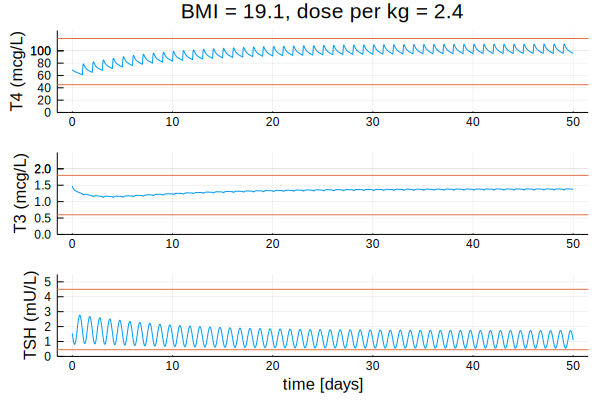

sol.prob.p[47] = 2.4338226471098627
(777.0 * sol[1, end]) / sol.prob.p[47] = 95.89216927925554
(651.0 * sol[4, end]) / sol.prob.p[47] = 1.3761162387701498


In [78]:
# simulate a random patient
patient = 1 #8, 100
# h = all_schneider[patient, Symbol("Ht.m")]
h = 1.62
w = 50.0
# w = all_schneider[patient, Symbol("Wt.kg")]
sex = isone(all_schneider[patient, Symbol("Sex")]) ? false : true
dial = [0.0; 0.88; 0.0; 0.88]
bmi = w / h^2
# T4dose = predicted_doses[patient] #mcg
T4dose = 120.0 #mcg

sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
    warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)
@show sol.prob.p[47]
@show 777.0 * sol[1, end] / sol.prob.p[47]
@show 651.0 * sol[4, end] / sol.prob.p[47]
ic, p = initialize(dial, true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)

plt = output_plot(sol, title="BMI = $(round(bmi, digits=1)), dose per kg = $(T4dose/w)")
display(plt)
# savefig(plt, dir * "obese_prediction.svg")

In [ ]:
#scaled (h = 1.62)
sol.prob.p[47] = 2.408936309385511
(777.0 * sol[1, end]) / sol.prob.p[47] = 63.72964872818975
(651.0 * sol[4, end]) / sol.prob.p[47] = 1.0661366313533598

#scaled (h = 1.72)
sol.prob.p[47] = 2.6189092257883706
(777.0 * sol[1, end]) / sol.prob.p[47] = 63.76682203323951
(651.0 * sol[4, end]) / sol.prob.p[47] = 0.9622493482386802

In [ ]:
# not scaled (h = 1.62)
sol.prob.p[47] = 2.408936309385511
(777.0 * sol[1, end]) / sol.prob.p[47] = 84.78696094145224
(651.0 * sol[4, end]) / sol.prob.p[47] = 1.4164666776846515

# not scaled (h = 1.72)
sol.prob.p[47] = 2.6189092257883706
(777.0 * sol[1, end]) / sol.prob.p[47] = 78.000552153298
(651.0 * sol[4, end]) / sol.prob.p[47] = 1.1759175859141024

### normal patient

In [ ]:
# simulate a random patient
patient = 2
h = all_schneider[patient, Symbol("Ht.m")]
w = all_schneider[patient, Symbol("Wt.kg")]
sex = isone(all_schneider[patient, Symbol("Sex")]) ? false : true
dial = [0.1; 0.88; 0.1; 0.88]
bmi = w / h^2
T4dose = predicted_doses[patient] #mcg

sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
    warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)
ic, p = initialize(dial, true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)

plt = output_plot(sol, title="BMI = $(round(bmi, digits=1)), dose per kg = $(T4dose/w)")
display(plt)
savefig(plt, dir * "normal_prediction.svg")

### underweight patien

In [ ]:
# simulate a random patient
patient = 73 #43
h = all_schneider[patient, Symbol("Ht.m")]
w = all_schneider[patient, Symbol("Wt.kg")]
sex = isone(all_schneider[patient, Symbol("Sex")]) ? false : true
dial = [0.1; 0.88; 0.1; 0.88]
bmi = w / h^2
T4dose = predicted_doses[patient] #mcg

sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
    warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)
ic, p = initialize(dial, true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender)

plt = output_plot(sol, title="BMI = $(round(bmi, digits=1)), dose per kg = $(T4dose/w)")
display(plt)
savefig(plt, dir * "skinny_prediction.svg")

## Plot predicted T4 dose vs BMI

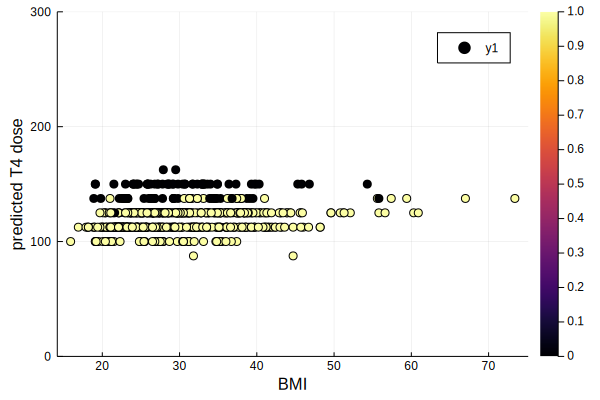

In [69]:
female_idx = findall(all_schneider[!, Symbol("Sex")] .== 1)
male_idx = findall(all_schneider[!, Symbol("Sex")] .== 0)

sex = all_schneider[!, Symbol("Sex")]
predicted_doses = readdlm(dir * "schneider_dosage_tshOnly_1.7.txt")
bmi = all_schneider[!, Symbol("BMI")]
height = all_schneider[!, Symbol("Ht.in")] .* 2.54
weight = all_schneider[!, Symbol("Wt.kg")]
plt = scatter(bmi, predicted_doses, ylabel="predicted T4 dose", 
    xlabel="BMI", marker_z=sex, ylim=(0, 300))
display(plt)
savefig(plt, dir * "predicted_t4Dose_vs_BMI.svg")

## Euthyroid dose vs BMI

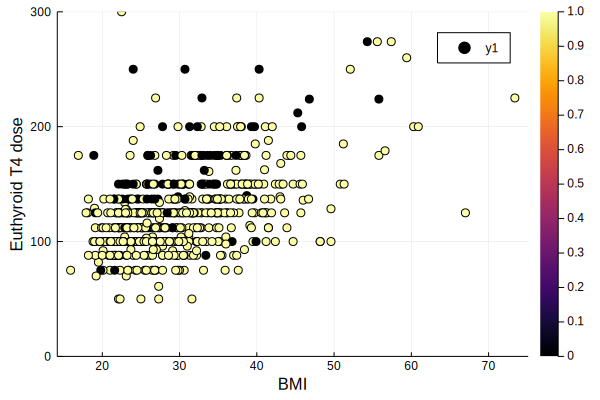

In [70]:
euthyroid_dose = all_schneider[!, Symbol("LT4.euthyroid.dose")]
bmi = all_schneider[!, Symbol("BMI")]
weight = all_schneider[!, Symbol("Wt.kg")]
height = all_schneider[!, Symbol("Ht.in")] .* 2.54
sex = all_schneider[!, Symbol("Sex")]

plt = scatter(bmi, euthyroid_dose, ylabel="Euthyroid T4 dose", xlabel="BMI", 
    marker_z=sex, ylim=(0, 300))
display(plt)
savefig(plt, dir * "euthyroid_t4Dose_vs_BMI.svg")

In [30]:
idx = findall(x -> x > 160, predicted_doses)

2-element Array{CartesianIndex{2},1}:
 CartesianIndex(94, 1)
 CartesianIndex(226, 1)

In [35]:
all_schneider[226, :]

,Surgeon,Race,Sex,Age,Wt.lb,Wt.kg,Ht.in,Ht.m,BMI,LT4.initial.dose
,String,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64
226,1,1,0,45.0,230,104.3,74.0,1.9,29.5,150.0


# Combination therapy

In [119]:
function simulate_combination(
    h::Real, # units meters
    w::Real, # units kg
    sex::Bool; # true = male, false = female
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, # mcgs
    T3dose::Real=0.0, # mcgs
    dosing_interval::Real=24.0, #hours
    warmup::Bool = true,
    fitting_index = Int[],
    parameters = Float64[],
    scale_plasma_ode=false,
    scale_slow_ode=false,
    scale_fast_ode=false,
    scale_allometric_exponent = false,
    scale_clearance_by_gender = false,
    )
    function add_dose!(integrator)
        integrator.u[10] += integrator.p[55]
        integrator.u[12] += integrator.p[56]
    end
    cbk = PeriodicCallback(add_dose!, dosing_interval) 

    # initialize thyrosim parameters
    ic, p = initialize(dial, true, h, w, sex, 
        fitting_index=fitting_index, p_being_optimized=parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode,
        scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    warmup && find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial

    # solve and return ode solution
    prob = ODEProblem(thyrosim,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob)
end

simulate_combination (generic function with 1 method)

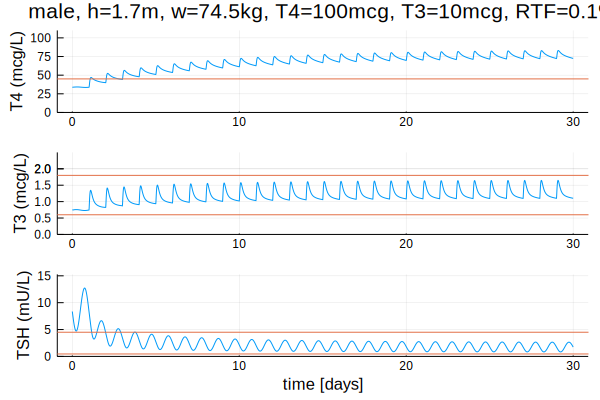

h = 1.7258770545335356, w = 74.45929777698095


In [160]:
sex = true # 1 = male, 0 = female
bmi = train_minimizer[findfirst(x -> x == (sex ? 65 : 66), fitting_index)]
h = train_minimizer[findfirst(x -> x == (sex ? 78 : 79), fitting_index)]
w = bmi * h^2
println("h = $h, w = $w")
T4 = 100
T3 = 10
RTF = 0.1
dial=[RTF; 0.88; RTF; 0.88]

sol = simulate_combination(h, w, sex, dial=dial, T4dose=T4, T3dose=T3,
    scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
    scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
    scale_clearance_by_gender=scale_clearance_by_gender, warmup=true,
    fitting_index=fitting_index, parameters=train_minimizer)
plt = output_plot(sol, title=(sex ? "male" : "female") *
    ", h=$(round(h, digits=1))m, w=$(round(w, digits=1))kg, T4=$(T4)mcg, T3=$(T3)mcg, RTF=$(RTF)%")

display(plt)
savefig(plt, dir * "combination_threapy_1.svg")